In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn')
%matplotlib inline 

In [2]:


confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')



In [4]:
cols = recoveries_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/19/20', '5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20',
       '5/25/20', '5/26/20', '5/27/20', '5/28/20'],
      dtype='object', length=132)

In [5]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [29]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())

In [30]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [31]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [32]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [37]:


from statsmodels.tsa.holtwinters import ExponentialSmoothing

daily_fit = ExponentialSmoothing(total_recovered,  trend='add', seasonal=None).fit()
daily_predict = daily_fit.predict(start=1, end=76)
test_predict = daily_fit.predict(start=1, end=66)

E:\Python\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [38]:
print('MAE:', mean_absolute_error(total_recovered, test_predict))
print('MSE:',mean_squared_error(total_recovered, test_predict))
from sklearn.metrics import r2_score
print(r2_score(total_recovered, test_predict))
print('RMSE:',math.sqrt(mean_squared_error(total_recovered, test_predict)))

MAE: 1827.8521381469463
MSE: 5970634.0738654295
0.9957001928646424
RMSE: 2443.4880957077385


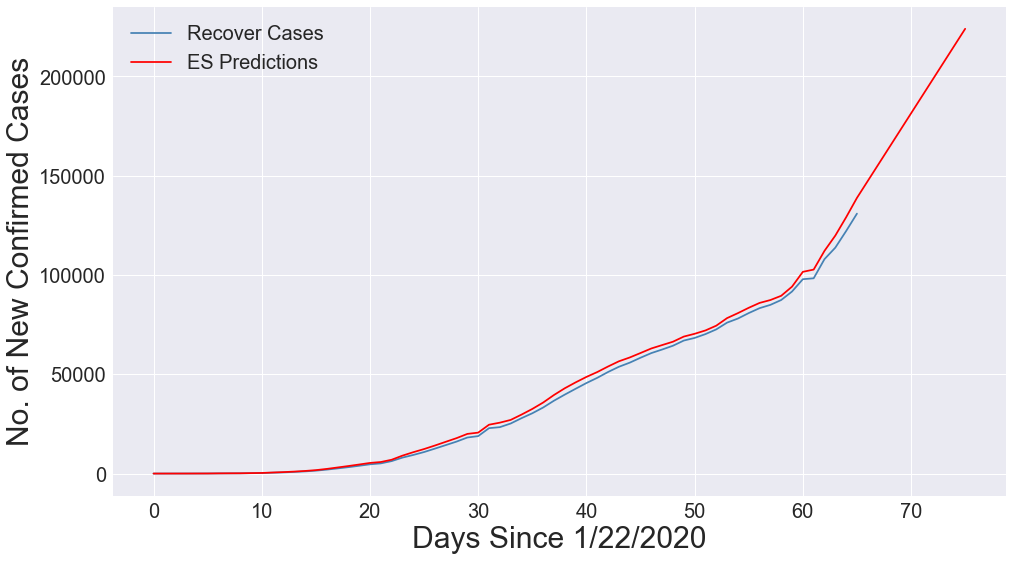

In [17]:
plt.figure(figsize=(16, 9))
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(total_recovered, color='steelblue')
plt.plot(daily_predict, color='red')
plt.legend(['Actual Cases', 'Predicted Cases'])
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('No. of New Confirmed Cases', size=30)
plt.legend(['Recover Cases', 'ES Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('SMOTCON.png')
plt.show()

MAE: 17016.08770063794
MSE: 480922814.5155735
RMSE: 21929.952451283916


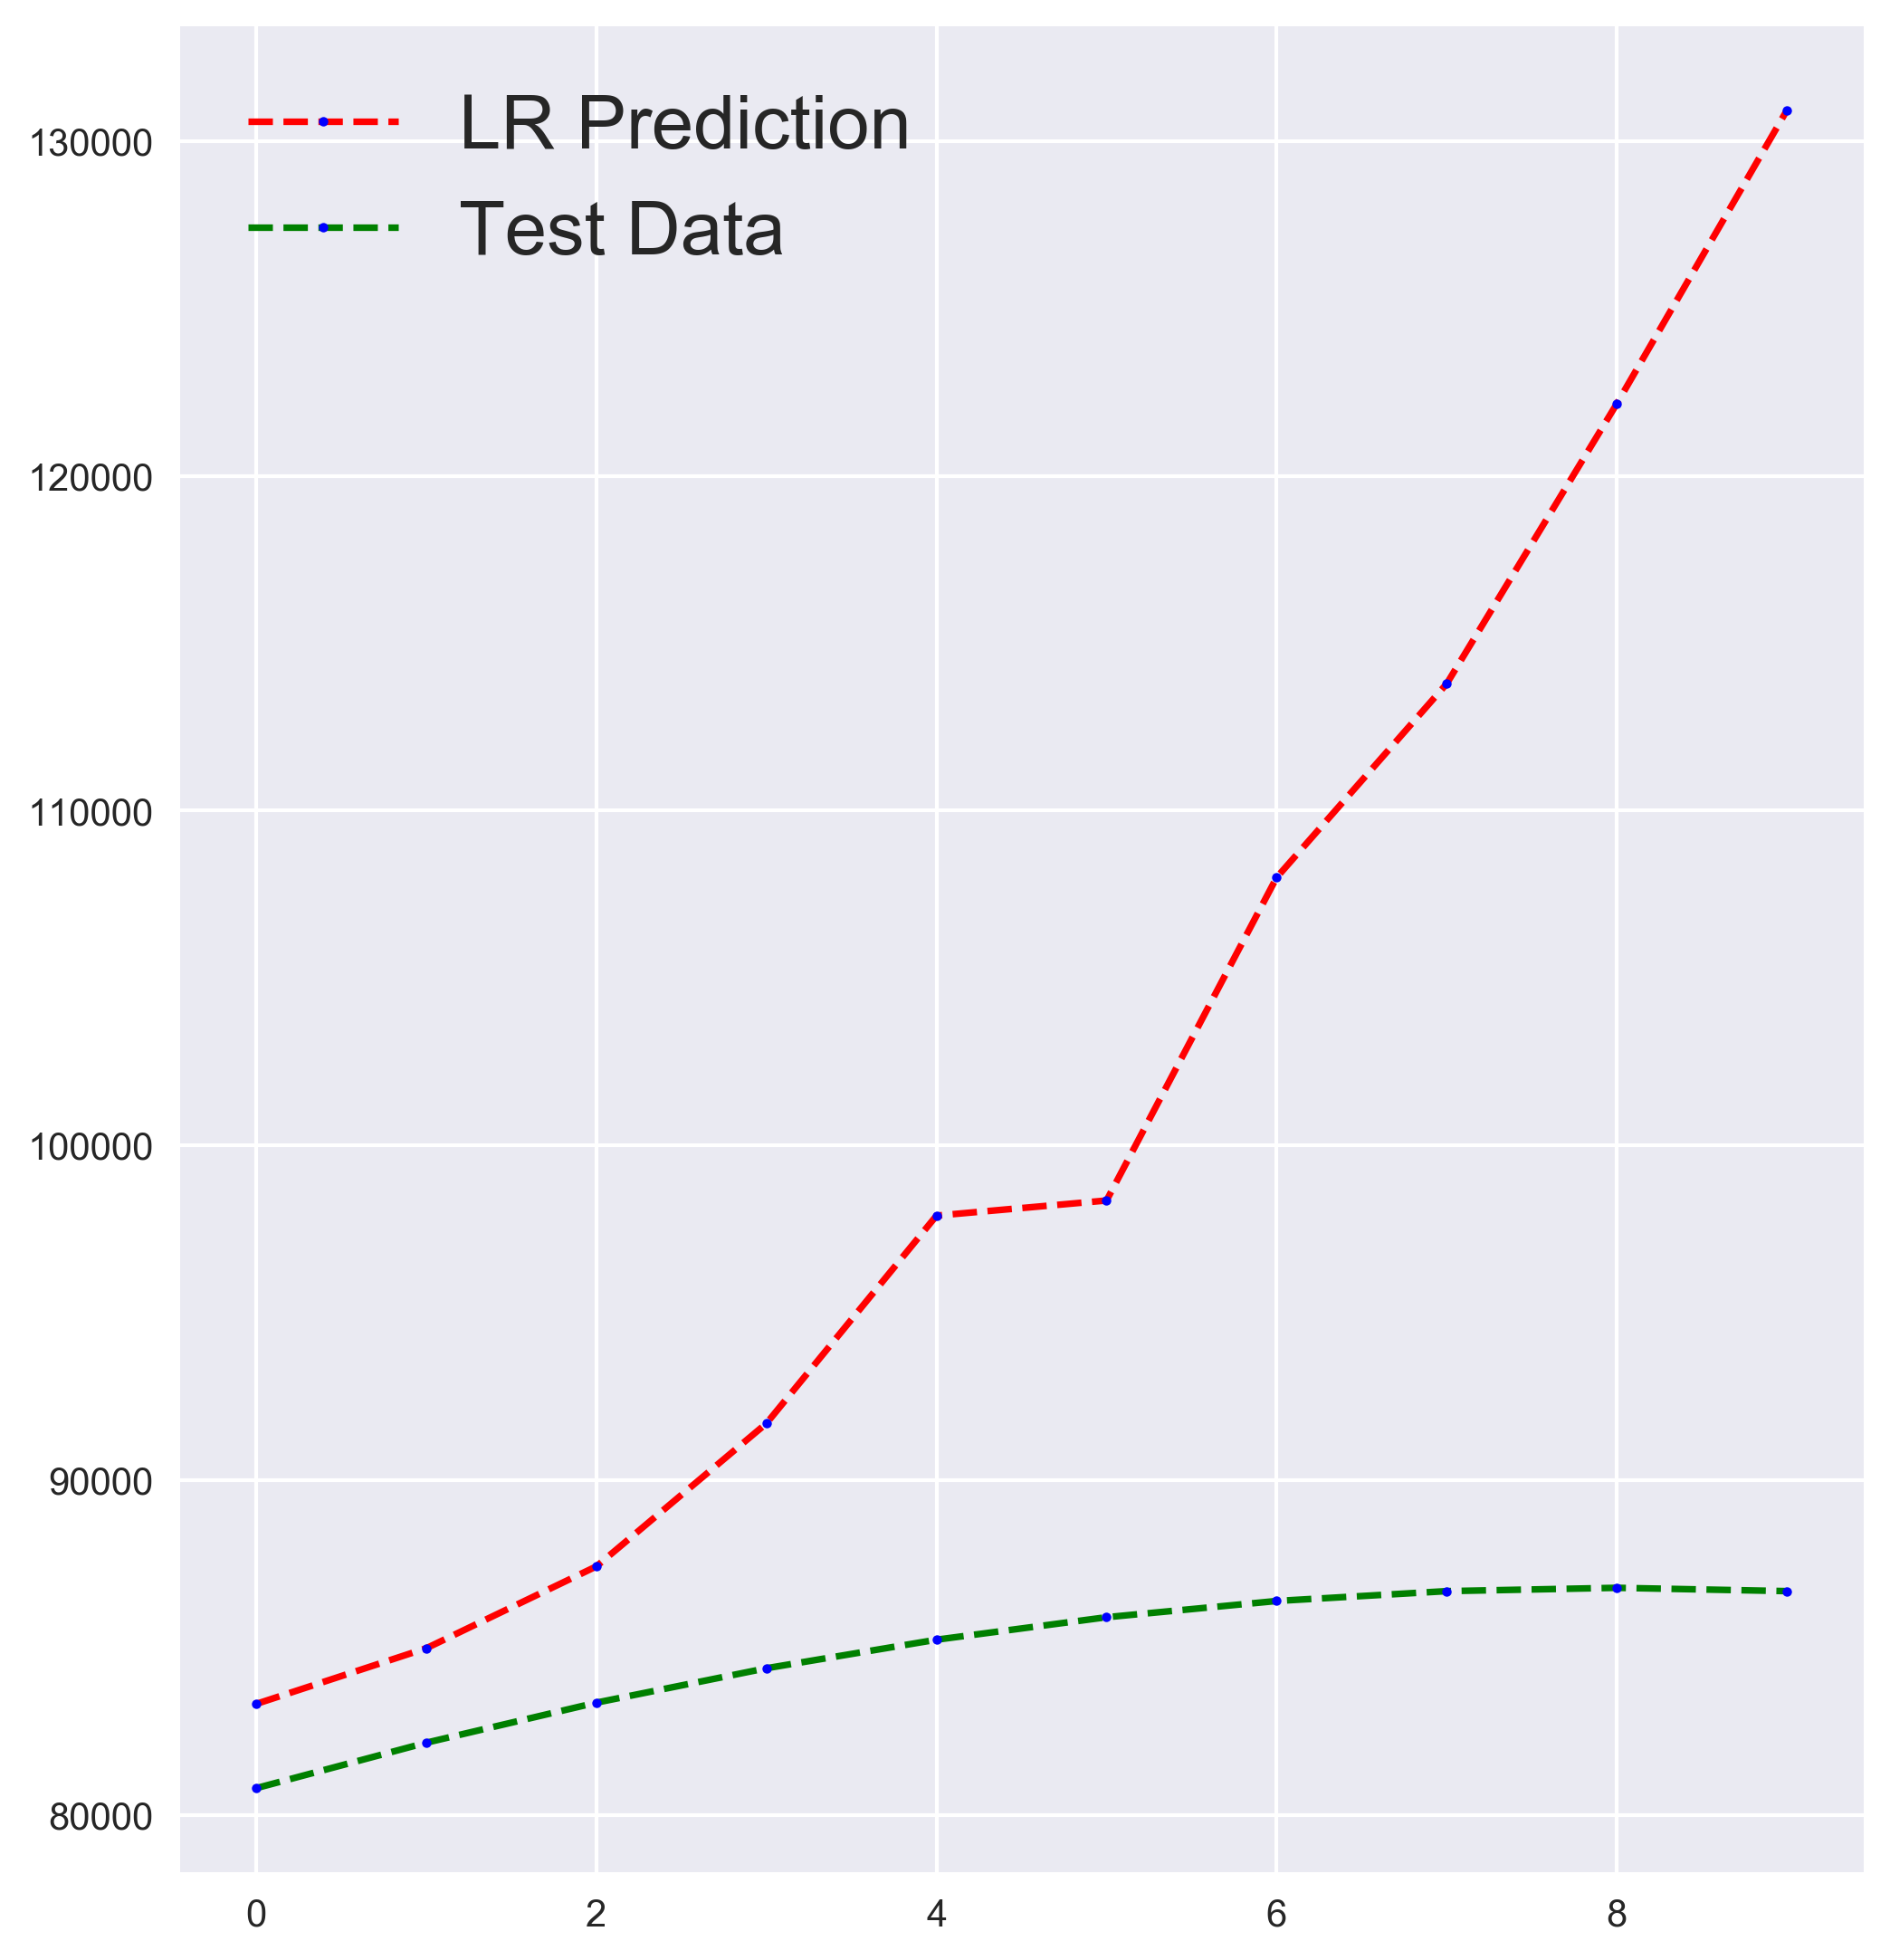

In [88]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))
print('RMSE:',math.sqrt(mean_squared_error(test_linear_pred, y_test_confirmed)))

plt.figure(figsize=(8, 9),dpi=300)
plt.plot(y_test_confirmed, linestyle='dashed', color='red', marker='.',
     markerfacecolor='blue', markersize=5)
plt.plot(test_linear_pred, linestyle='dashed', color='green', marker='.',
     markerfacecolor='blue', markersize=5)
plt.legend(['LR Prediction', 'Test Data'], prop={'size': 20})
#plt.savefig('recoverLR')

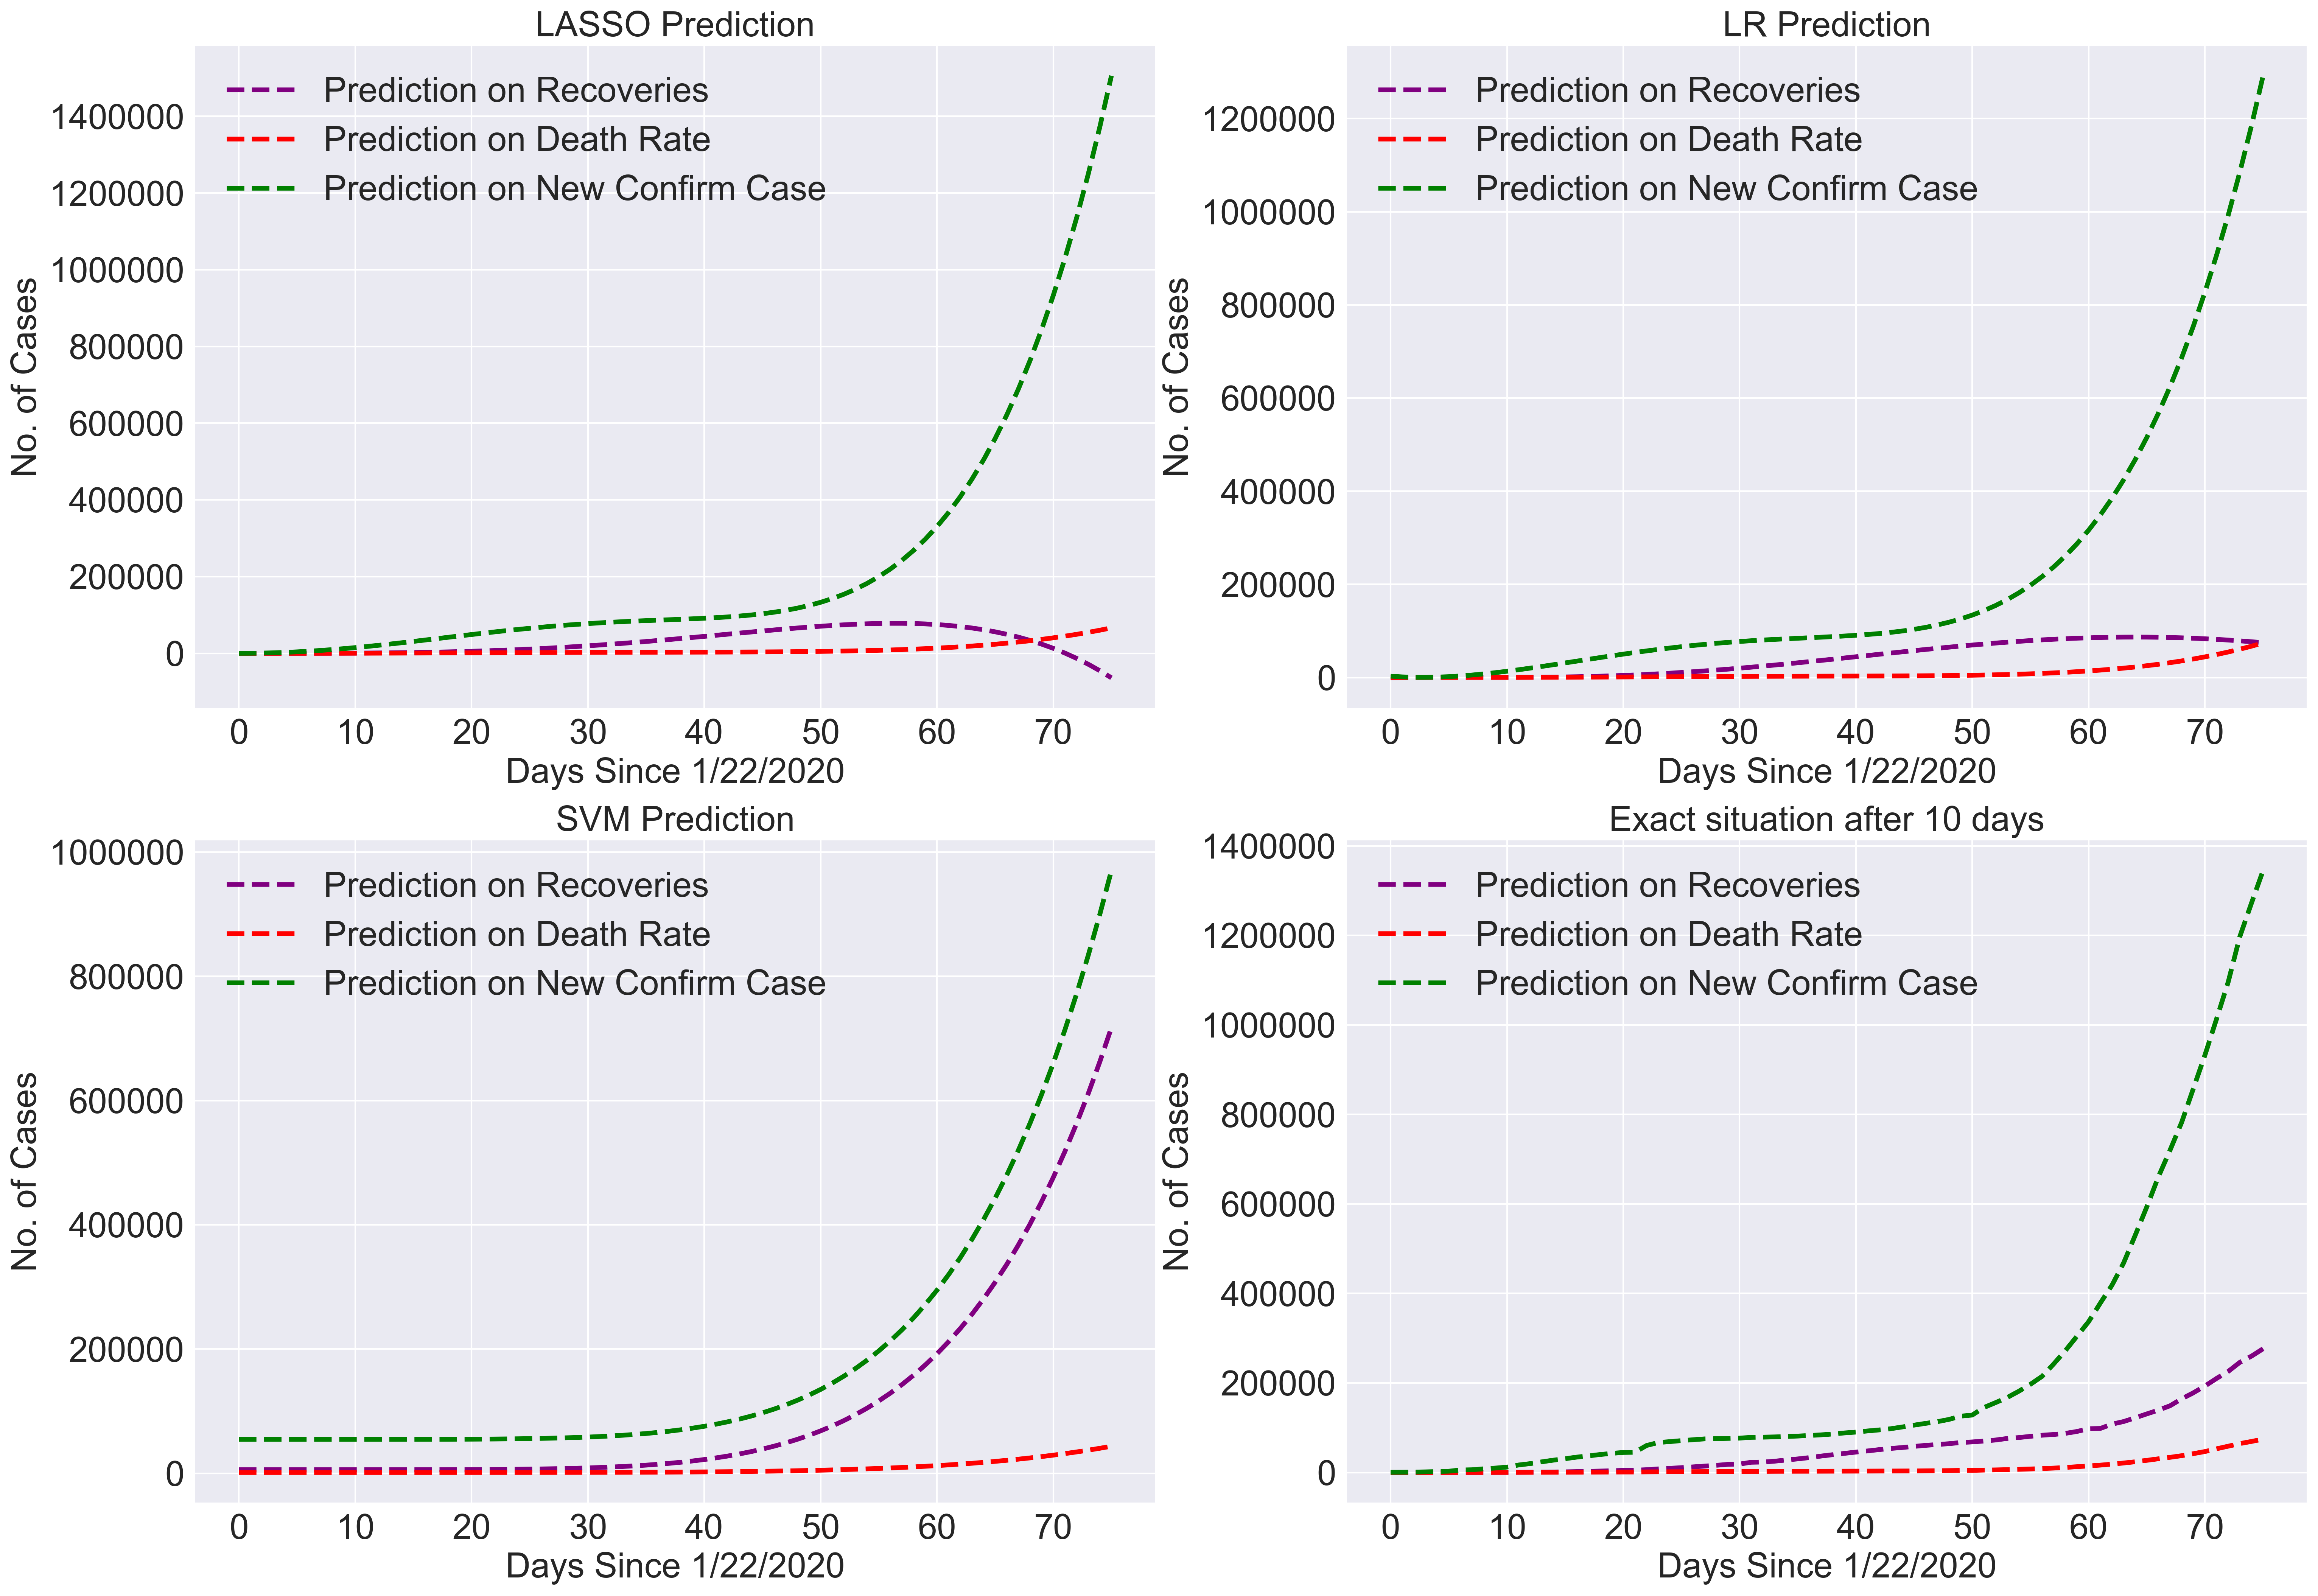

In [865]:
plt.figure(figsize=(24,17),dpi=300)

plt.subplot(2, 2, 1)
plt.title('LASSO Prediction', size=22)
plt.plot(future_forcast1, lassorec, linestyle='dashed', color='purple',linewidth=3)
plt.plot(future_forcast1, lassoDeath, linestyle='dashed', color='red',linewidth=3)
plt.plot(future_forcast1, lassoConfirm, linestyle='dashed', color='green',
     markerfacecolor='blue',linewidth=3)
plt.legend(['Prediction on Recoveries', 'Prediction on Death Rate','Prediction on New Confirm Case'], prop={'size': 22})
plt.xlabel('Days Since 1/22/2020', size=22)
plt.ylabel('No. of Cases', size=22)
plt.xticks(size=22)
plt.yticks(size=22)


plt.subplot(2, 2, 2)
plt.title('LR Prediction', size=22)
plt.plot(future_forcast1, LrRec, linestyle='dashed', color='purple',linewidth=3)
plt.plot(future_forcast1, LrDeath, linestyle='dashed', color='red',linewidth=3)
plt.plot(future_forcast1, LrConfirm, linestyle='dashed', color='green',
     markerfacecolor='blue',linewidth=3)
plt.legend(['Prediction on Recoveries', 'Prediction on Death Rate','Prediction on New Confirm Case'], prop={'size': 22})
plt.xlabel('Days Since 1/22/2020', size=22)
plt.ylabel('No. of Cases', size=22)
plt.xticks(size=22)
plt.yticks(size=22)


plt.subplot(2, 2, 3)
plt.title('SVM Prediction', size=22)
plt.plot(future_forcast1, SVMRec, linestyle='dashed', color='purple',linewidth=3)
plt.plot(future_forcast1, SVMDeath, linestyle='dashed', color='red',linewidth=3)
plt.plot(future_forcast1, SVMConfirm, linestyle='dashed', color='green',
     markerfacecolor='blue',linewidth=3)
plt.legend(['Prediction on Recoveries', 'Prediction on Death Rate','Prediction on New Confirm Case'], prop={'size': 22})
plt.xlabel('Days Since 1/22/2020', size=22)
plt.ylabel('No. of Cases', size=22)
plt.xticks(size=22)
plt.yticks(size=22)

plt.subplot(2, 2, 4)
plt.title('Exact situation after 10 days', size=22)
plt.plot(adjusted_dates, total_recovered, linestyle='dashed', color='purple',linewidth=3)
plt.plot(adjusted_dates, total_deaths, linestyle='dashed', color='red',linewidth=3)
plt.plot(adjusted_dates, world_cases, linestyle='dashed', color='green',
     markerfacecolor='blue',linewidth=3)
plt.legend(['Prediction on Recoveries', 'Prediction on Death Rate','Prediction on New Confirm Case'], prop={'size': 22})
plt.xlabel('Days Since 1/22/2020', size=22)
plt.ylabel('No. of Cases', size=22)
plt.xticks(size=22)
plt.yticks(size=22)
plt.savefig('allnew.png')

In [102]:
adDate=adjusted_dates
TotalDeath=total_deaths
TotalRec=total_recovered
TotalCase=world_cases

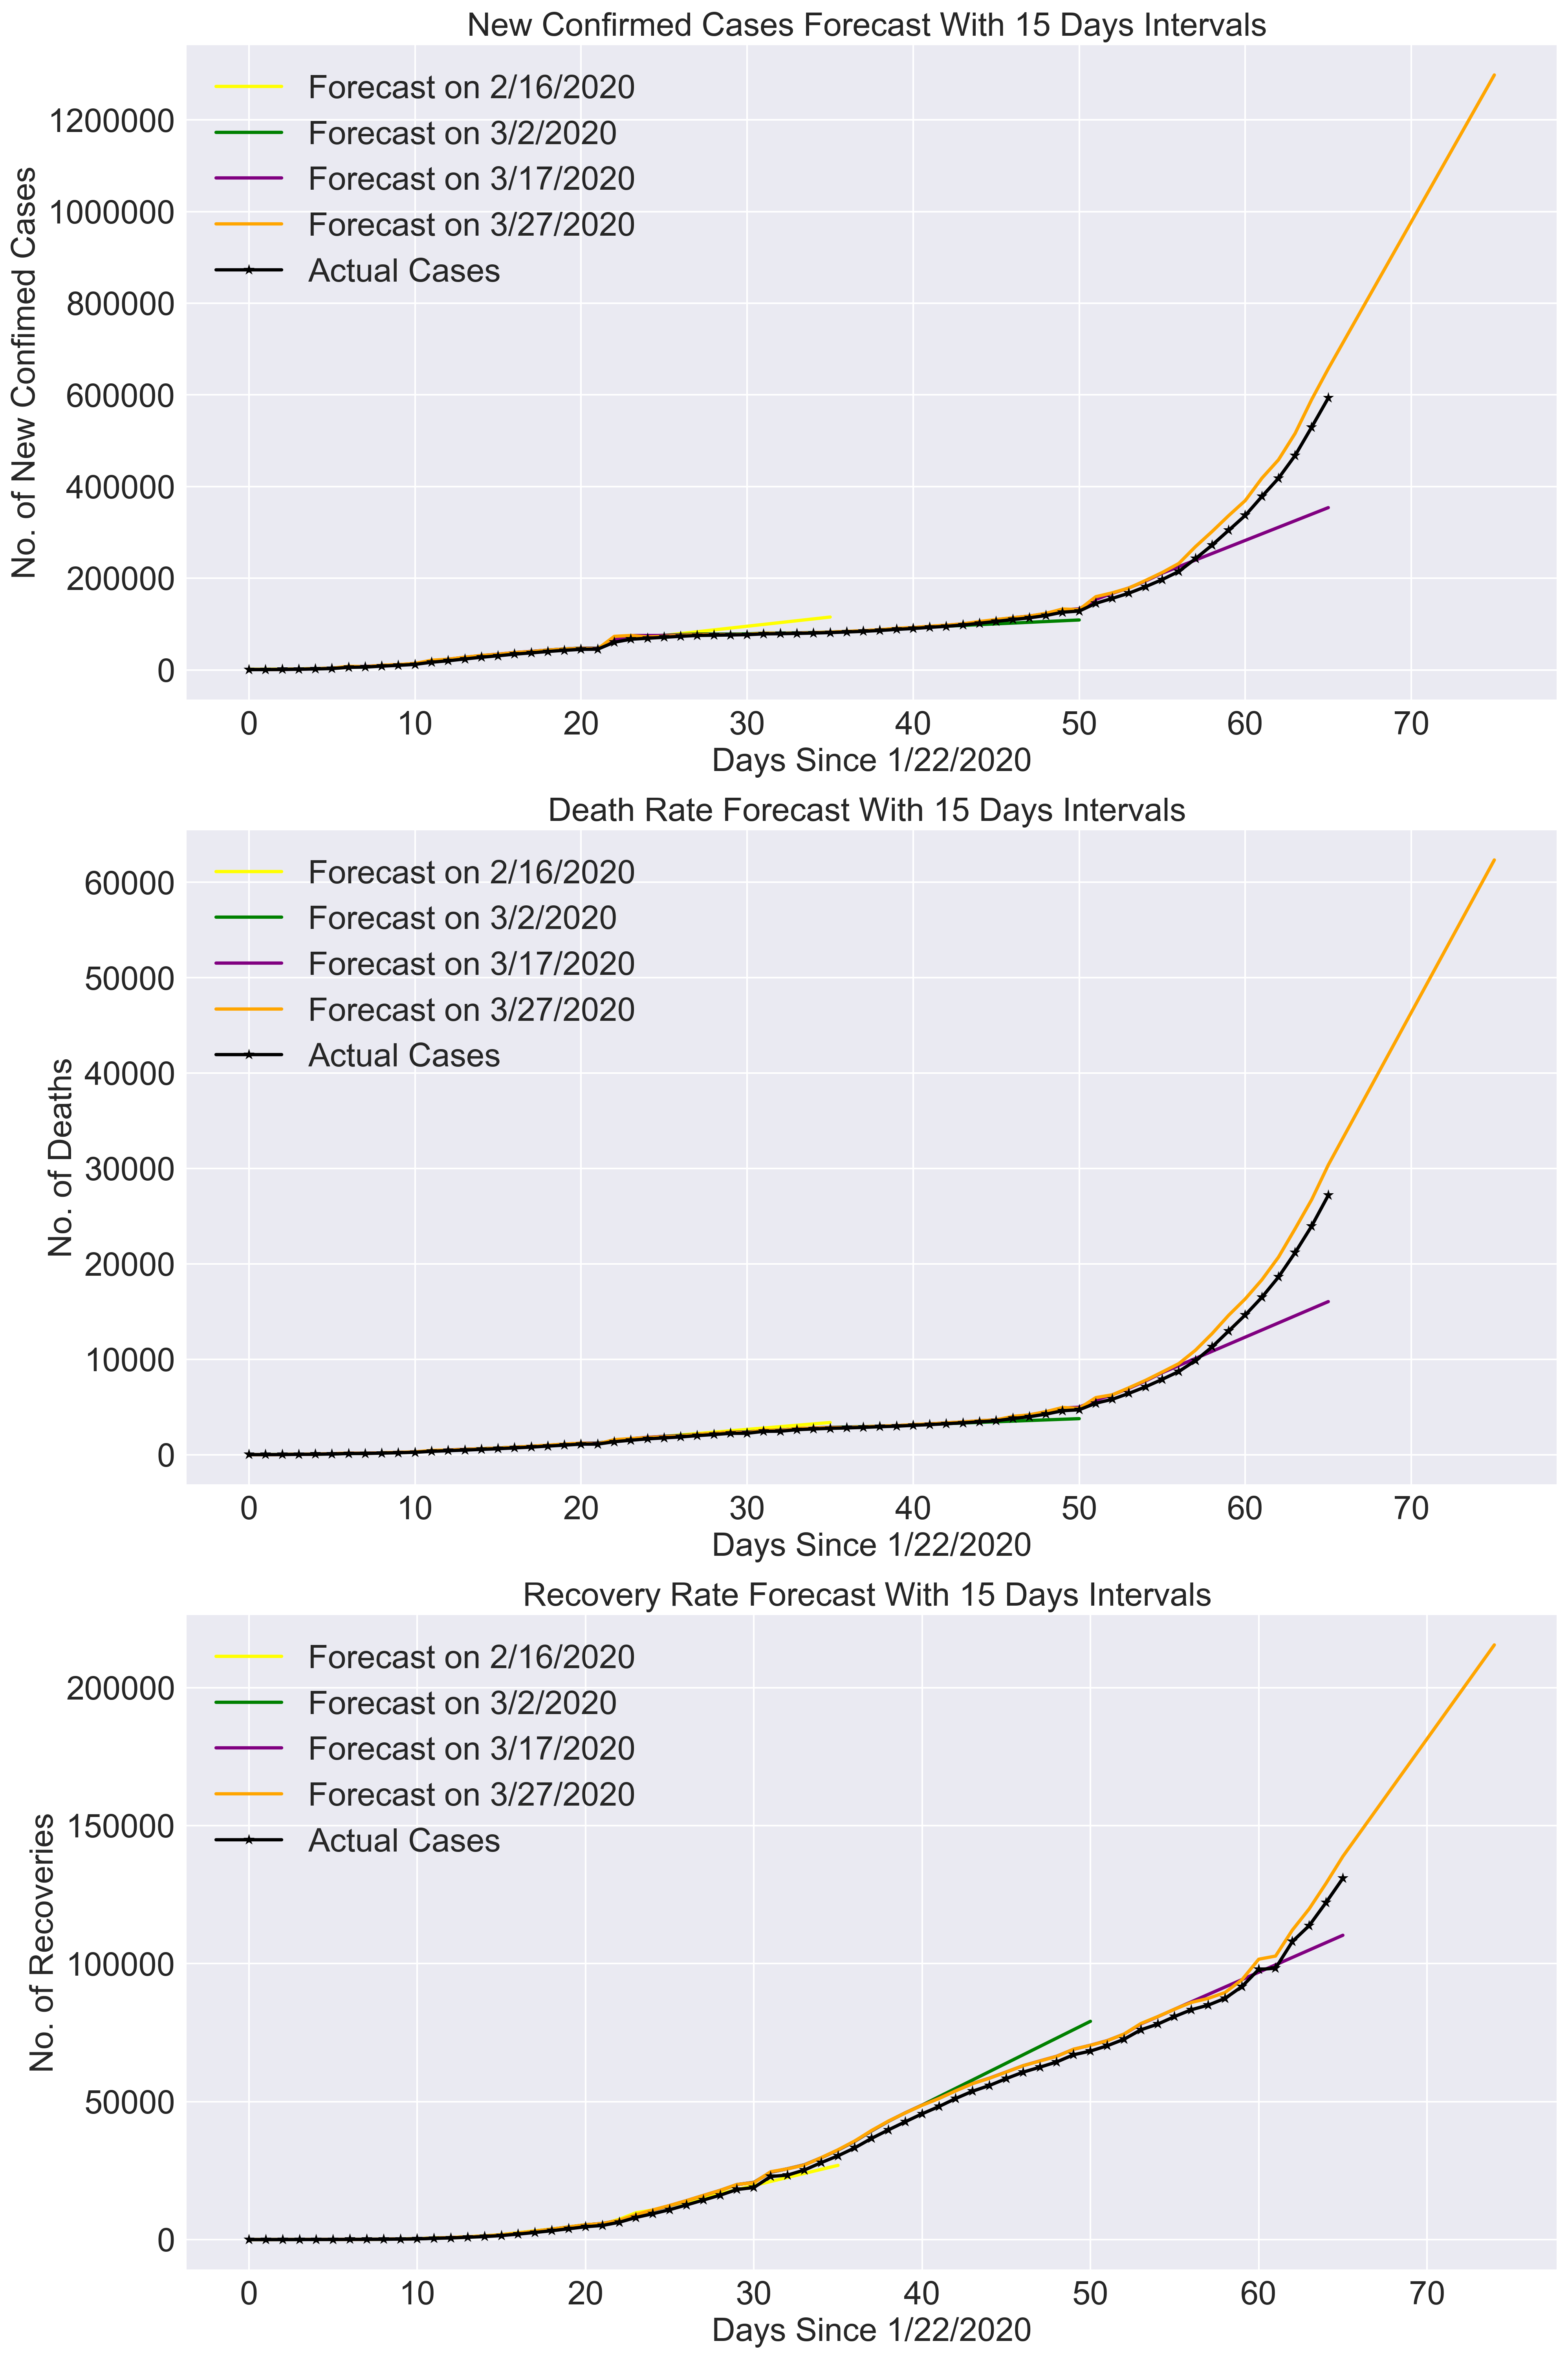

In [174]:
plt.figure(figsize=(15,25),dpi=300)

plt.subplot(3, 1, 1)
plt.title('New Confirmed Cases Forecast With 15 Days Intervals ', size=20)
plt.plot(for216_2020, linestyle='-', color='yellow',linewidth=2)
plt.plot(for229_2020, linestyle='-', color='green',linewidth=2)
plt.plot(for317_2020, linestyle='-', color='purple',linewidth=2)
plt.plot(LrConfirm, linestyle='-', color='orange',linewidth=2)
plt.plot(adDate, TotalCase, linestyle='-', color='black',linewidth=2, marker='*')
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('No. of New Confimed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(['Forecast on 2/16/2020','Forecast on 3/2/2020','Forecast on 3/17/2020' ,'Forecast on 3/27/2020','Actual Cases'], prop={'size': 20})


plt.subplot(3, 1, 2)
plt.title('Death Rate Forecast With 15 Days Intervals ', size=20)
plt.plot(forD216_2020, linestyle='-', color='yellow',linewidth=2)
plt.plot(forD229_2020, linestyle='-', color='green',linewidth=2)
plt.plot(forD317_2020, linestyle='-', color='purple',linewidth=2)
plt.plot(lassoDeath, linestyle='-', color='orange',linewidth=2)
plt.plot(adDate, TotalDeath, linestyle='-', color='black',linewidth=2, marker='*')
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('No. of Deaths', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(['Forecast on 2/16/2020','Forecast on 3/2/2020','Forecast on 3/17/2020' ,'Forecast on 3/27/2020','Actual Cases'], prop={'size': 20})


plt.subplot(3, 1, 3)
plt.title('Recovery Rate Forecast With 15 Days Intervals ', size=20)
plt.plot(forR216_2020, linestyle='-', color='yellow',linewidth=2)
plt.plot(forR229_2020, linestyle='-', color='green',linewidth=2)
plt.plot(forR317_2020, linestyle='-', color='purple',linewidth=2)
plt.plot(lassorec, linestyle='-', color='orange',linewidth=2)
plt.plot(adDate, TotalRec, linestyle='-', color='black',linewidth=2, marker='*')
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('No. of Recoveries', size=20)
plt.legend(['Forecast on 2/16/2020','Forecast on 3/2/2020','Forecast on 3/17/2020' ,'Forecast on 3/27/2020','Actual Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('intervalsnew.png')

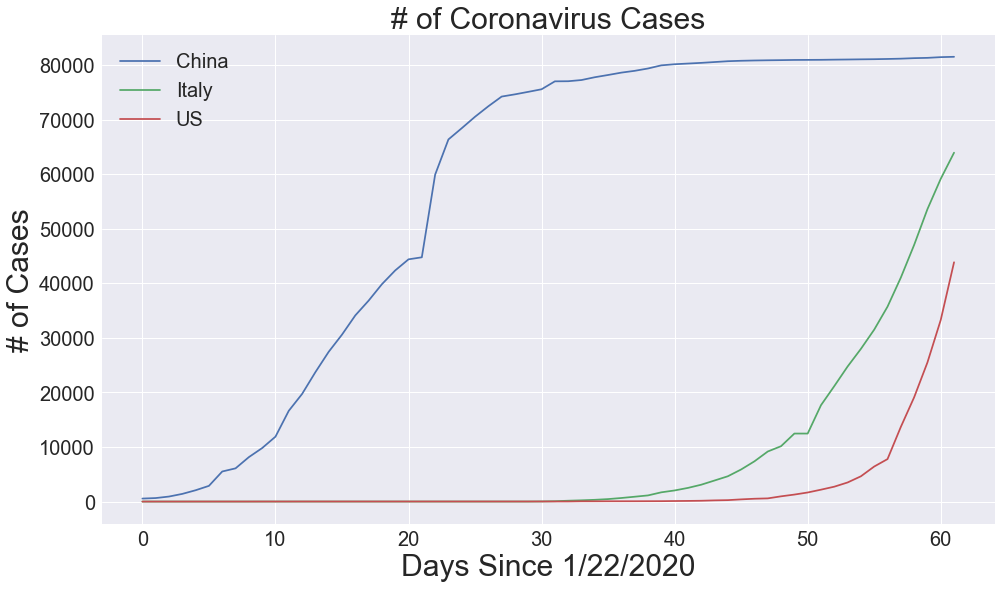

In [67]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

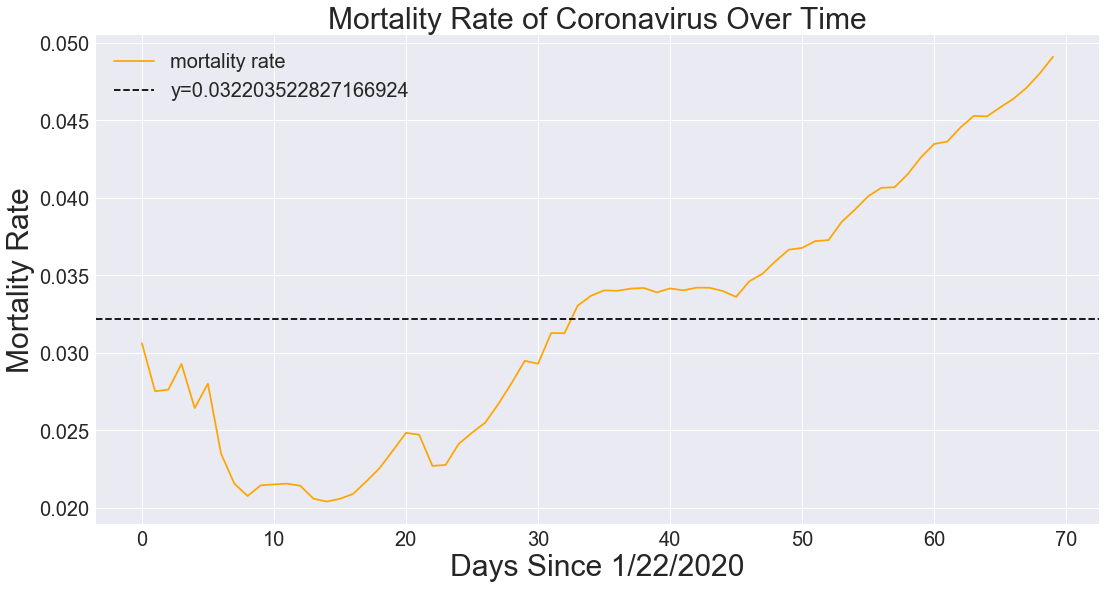

In [93]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [32]:


latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
unique_countries =  list(confirmed_df['Country/Region'].unique())
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [33]:


unique_provinces =  list(confirmed_df['Province/State'].unique())

province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==unique_provinces[i]].sum()

# number of cases per province/state/city
print('Confirmed Cases by Province/States:')
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Confirmed Cases by Province/States:
Hubei: 67802 cases
Quebec: 4611 cases
Ontario: 2392 cases
New South Wales: 2182 cases
Guangdong: 1501 cases
Henan: 1276 cases
Zhejiang: 1257 cases
Hunan: 1018 cases
British Columbia: 1013 cases
Anhui: 990 cases
Victoria: 968 cases
Jiangxi: 937 cases
Queensland: 781 cases
Shandong: 774 cases
Hong Kong: 765 cases
Alberta: 754 cases
Jiangsu: 646 cases
Beijing: 580 cases
Chongqing: 579 cases
Sichuan: 552 cases
Shanghai: 516 cases
Heilongjiang: 484 cases
Western Australia: 392 cases
South Australia: 367 cases
Fujian: 345 cases
Hebei: 323 cases
Reunion: 281 cases
Shaanxi: 255 cases
Guangxi: 254 cases
Saskatchewan: 193 cases
Yunnan: 182 cases
Tianjin: 176 cases
Newfoundland and Labrador: 175 cases
Nova Scotia: 173 cases
Faroe Islands: 173 cases
Channel Islands: 172 cases
Hainan: 168 cases
Guizhou: 146 cases
Liaoning: 140 cases
Gansu: 138 cases
Shanxi: 137 cases
Martinique: 135 cases
Manitoba: 127 cases
Guadeloupe: 125 cases
Inner Mongolia: 111 cases
Jilin: 

In [97]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

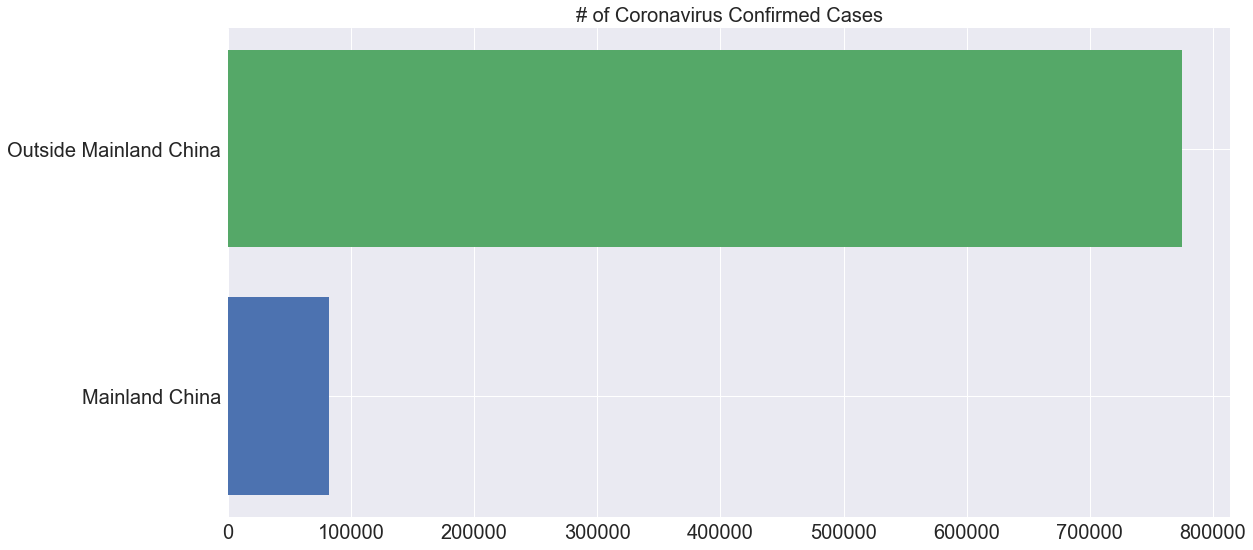

In [100]:
china_confirmed = latest_confirmed[confirmed_df['Country/Region']=='China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [101]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 775208 cases:
Mainland China: 82279 cases
Total: 857487 cases


In [34]:


# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)



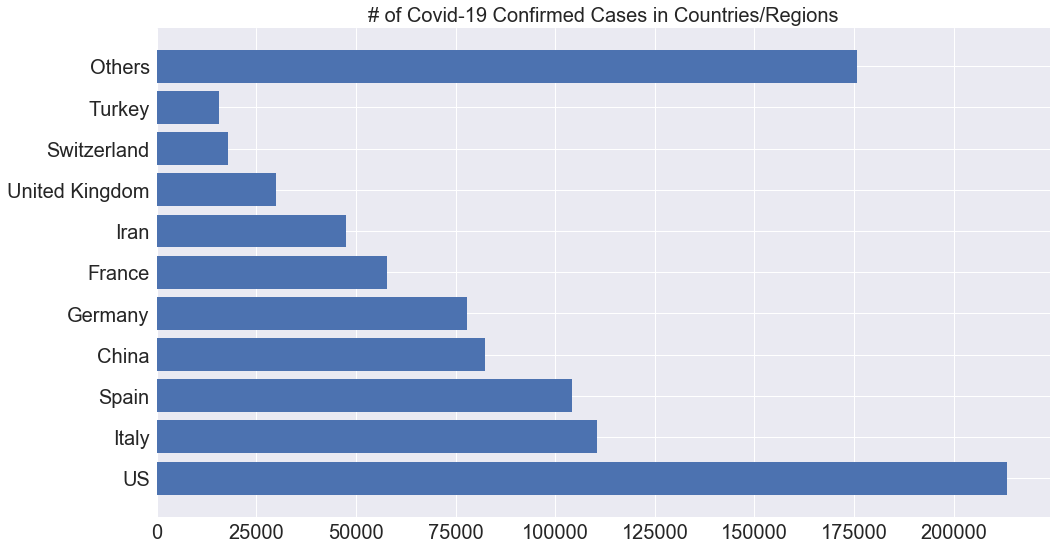

In [35]:


plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()



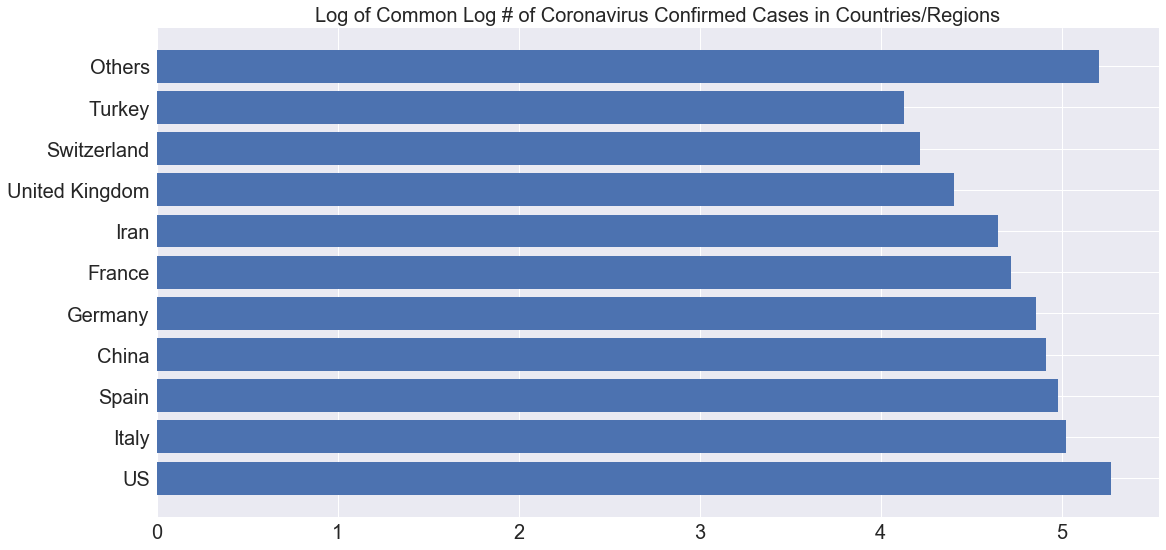

In [104]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [36]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

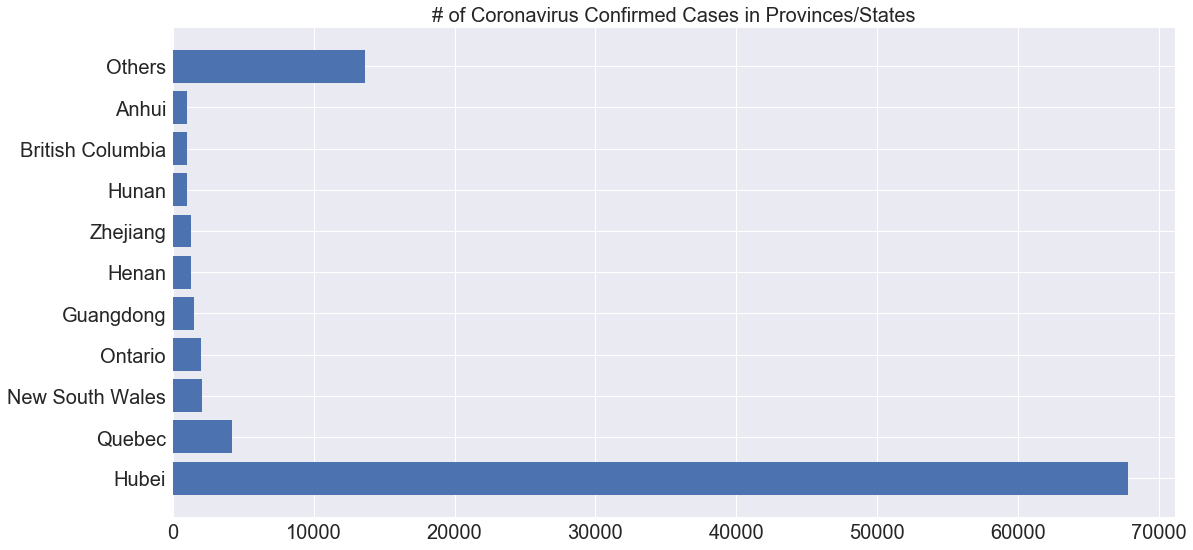

In [106]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

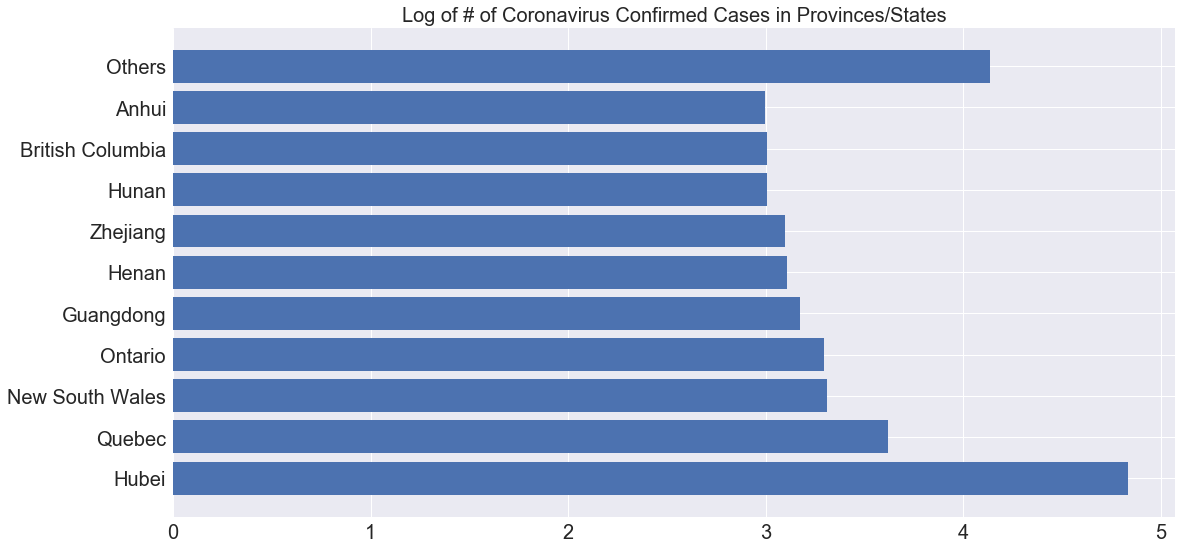

In [107]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

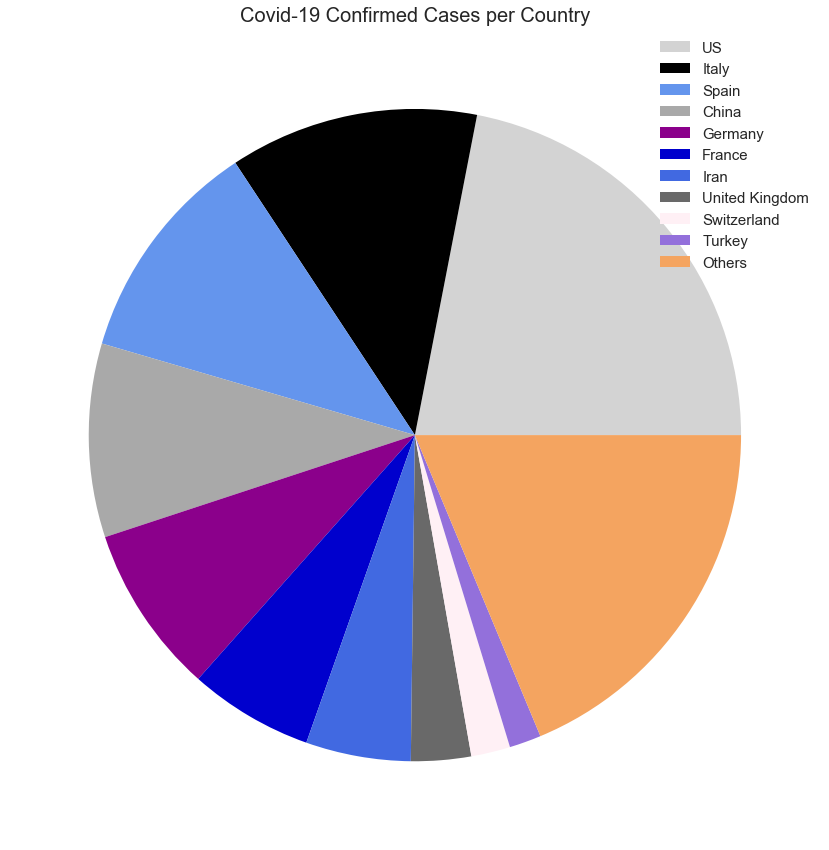

In [108]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()

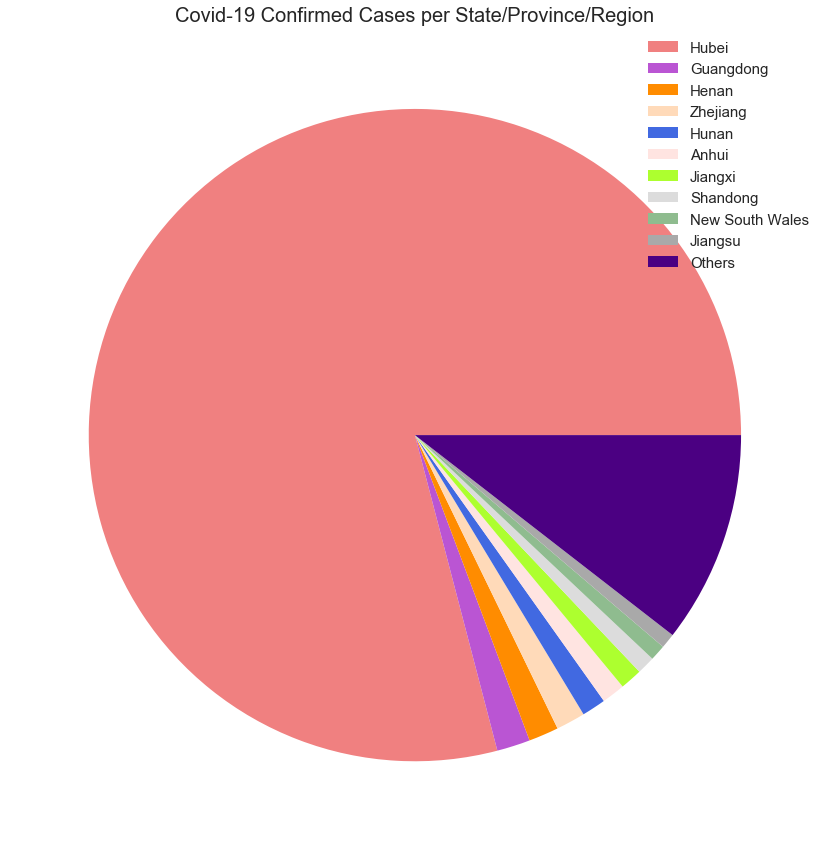

In [167]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per State/Province/Region', size=20)
plt.pie(visual_confirmed_cases2, colors=c)
plt.legend(visual_unique_provinces, loc='best', fontsize=15)
plt.show()

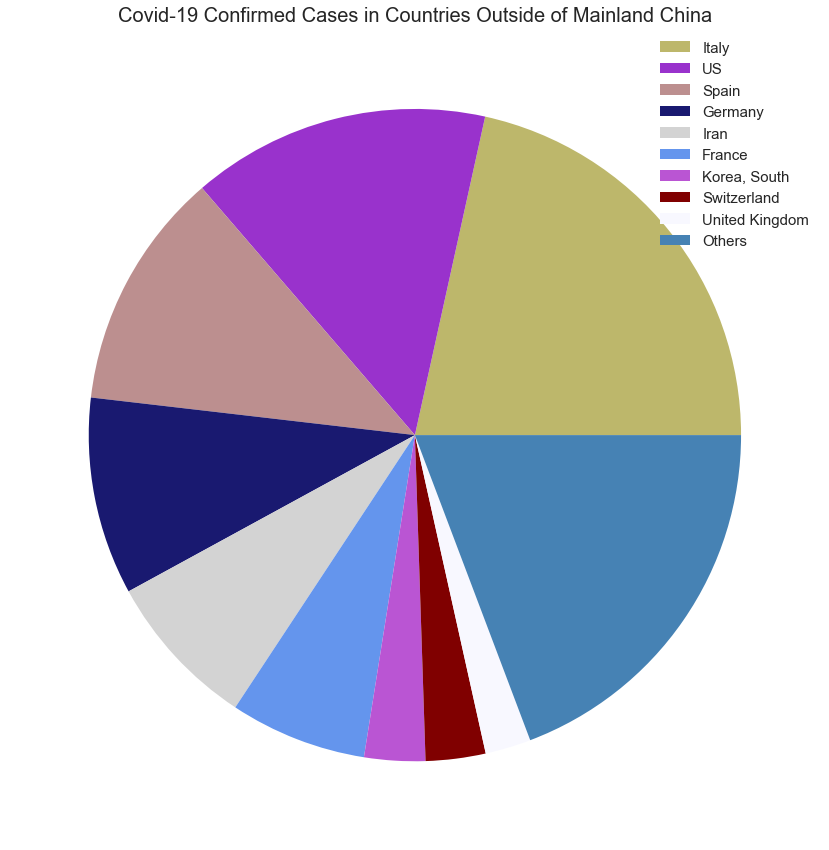

In [168]:


c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China', size=20)
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best', fontsize=15)
plt.show()



In [37]:
# looking at Chinese provinces
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)
    
china_regions = [k for k, v in sorted(zip(china_regions, china_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(china_regions)):
    china_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==china_regions[i]].sum()  

china_regions_10 = china_regions[:10]
china_regions_10.append('Others')
china_confirmed_cases_10 = china_confirmed_cases[:10]
china_confirmed_cases_10.append(np.sum(china_confirmed_cases[10:]))

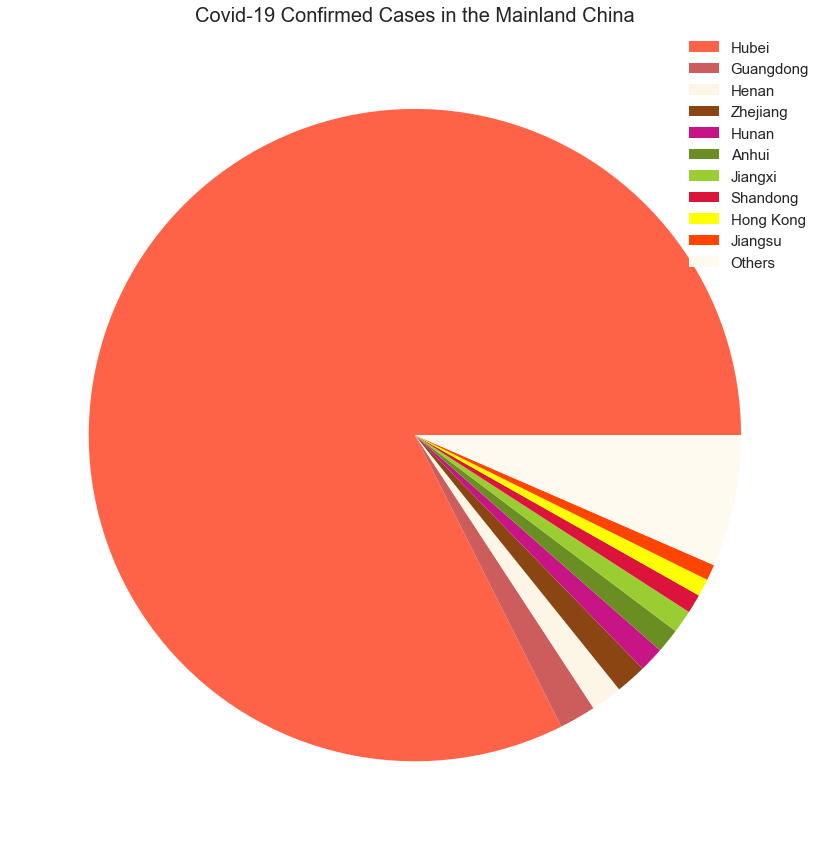

In [110]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the Mainland China', size=20)
plt.pie(china_confirmed_cases_10, colors=c)
plt.legend(china_regions_10, loc='best', fontsize=15)
plt.show()

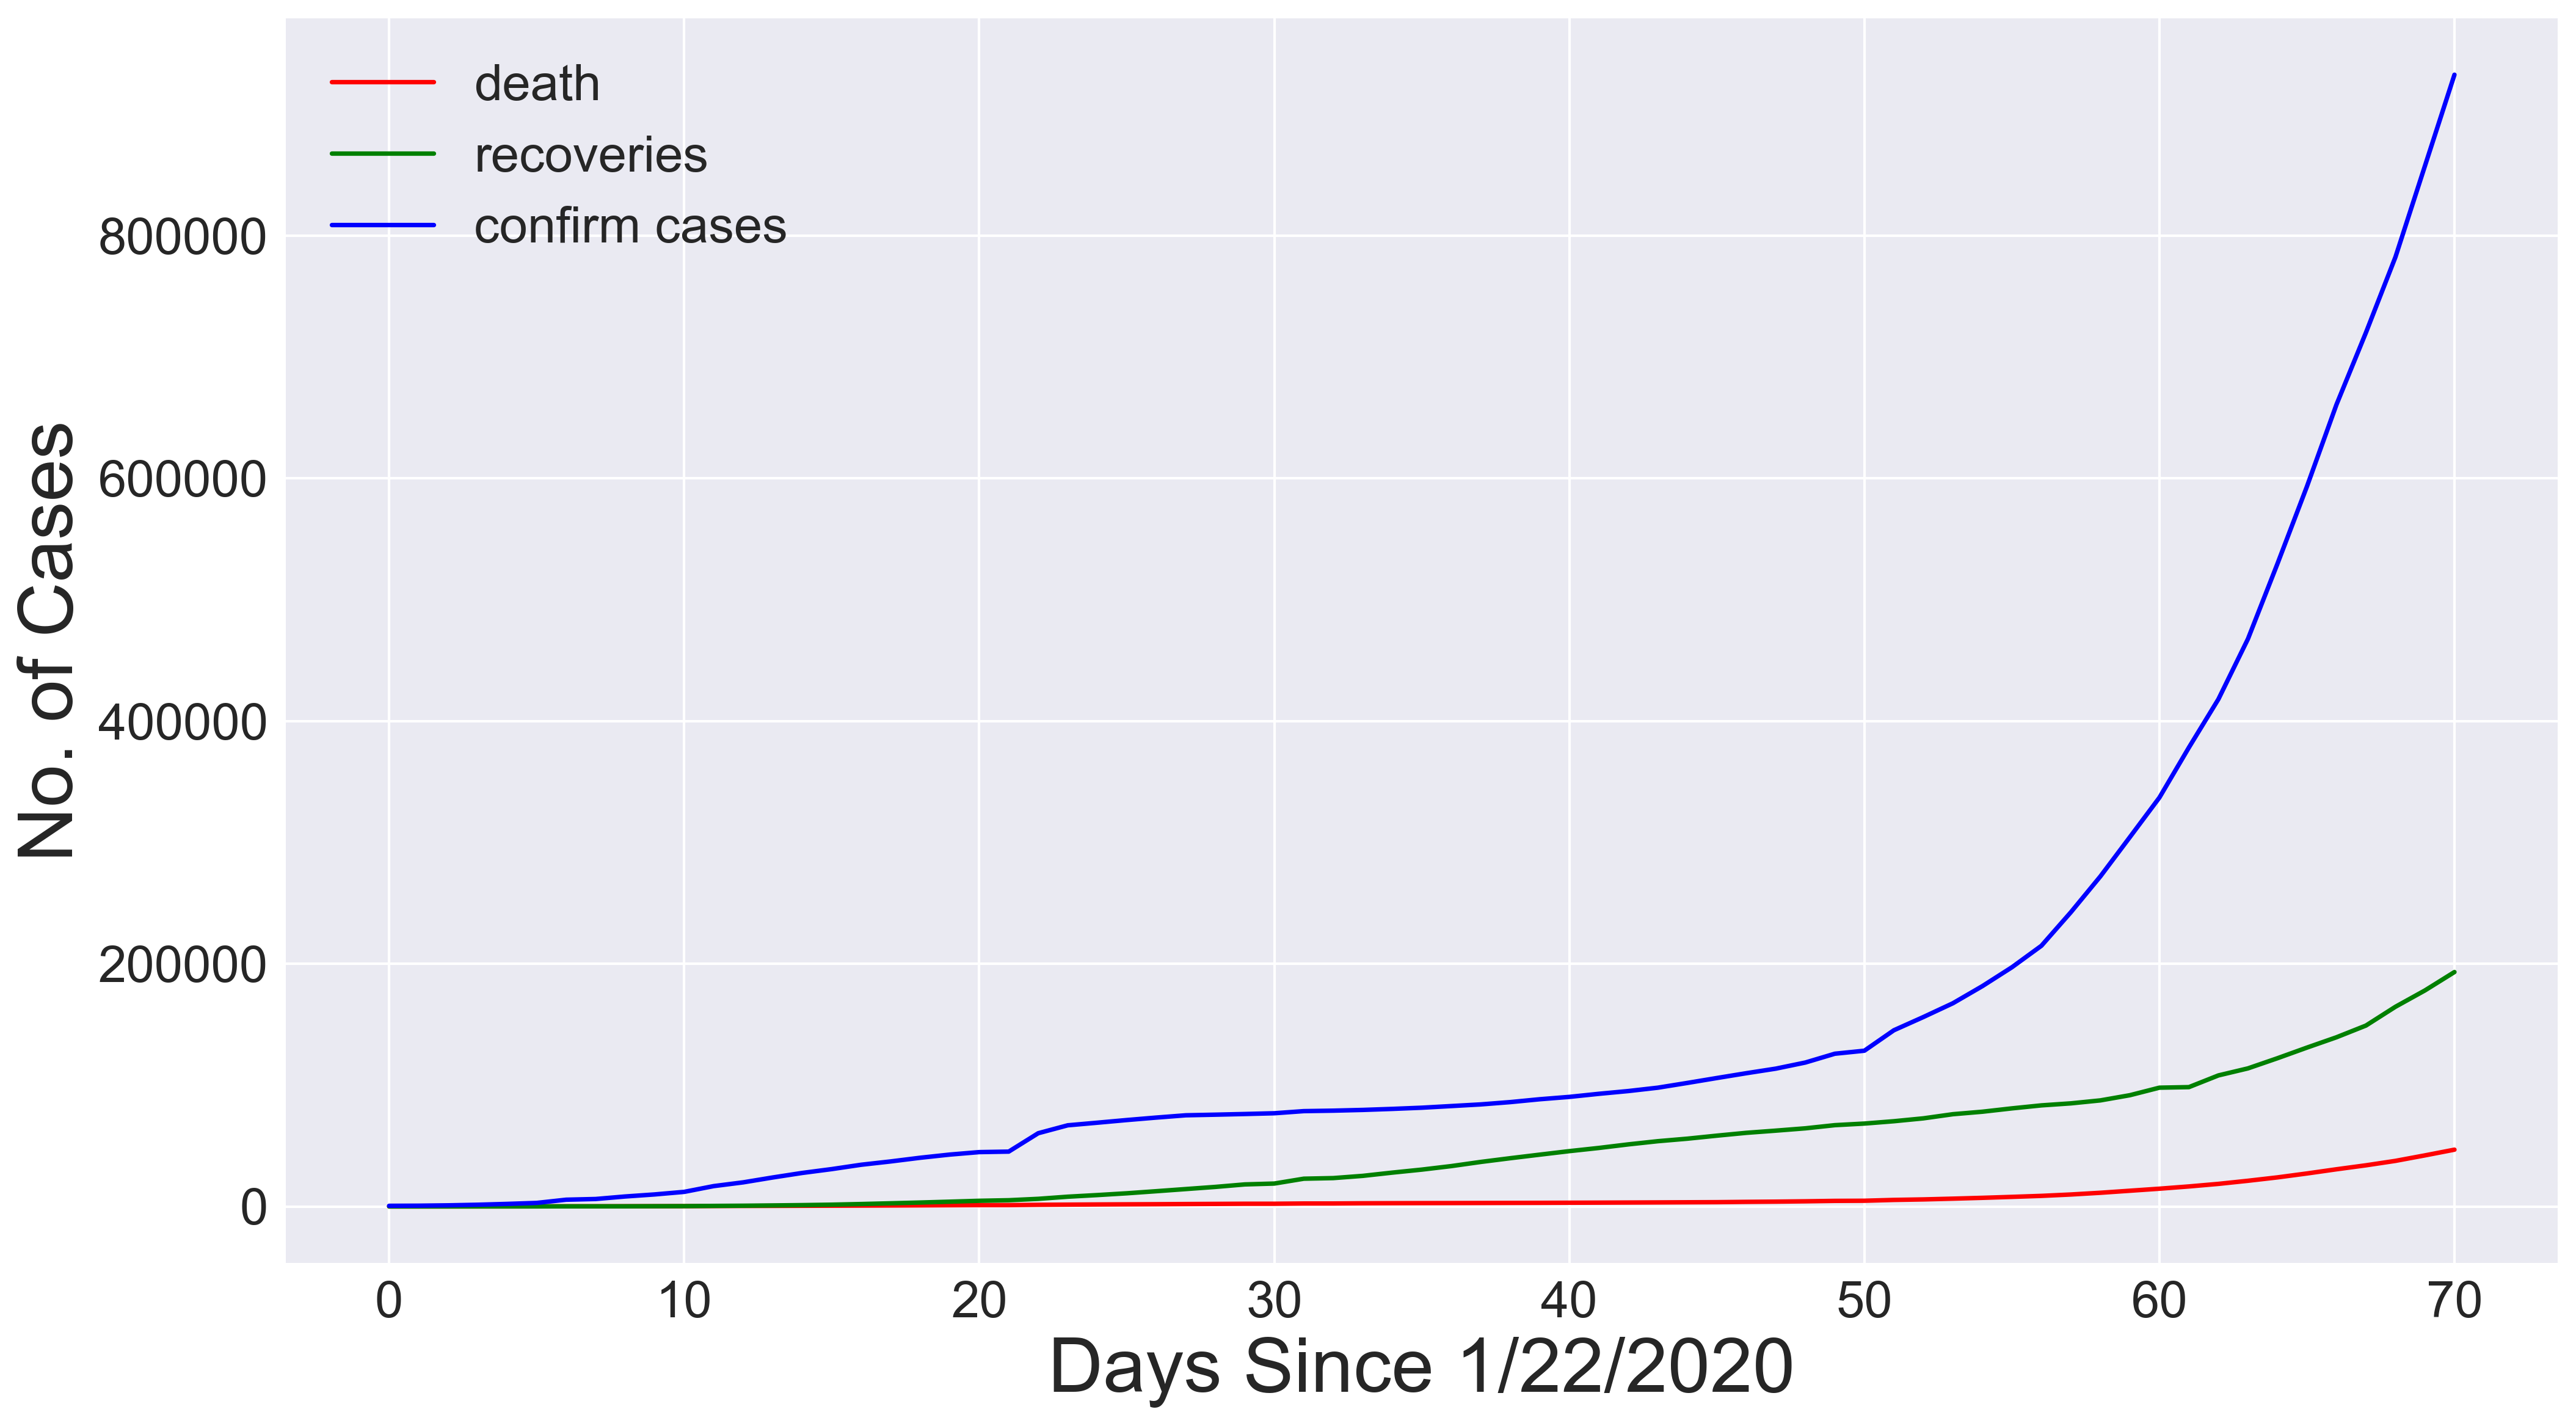

In [38]:
plt.figure(figsize=(16, 9),dpi=300)
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.plot(adjusted_dates, world_cases, color='blue')
plt.legend(['death', 'recoveries','confirm cases'], loc='best', fontsize=20)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('cov19')

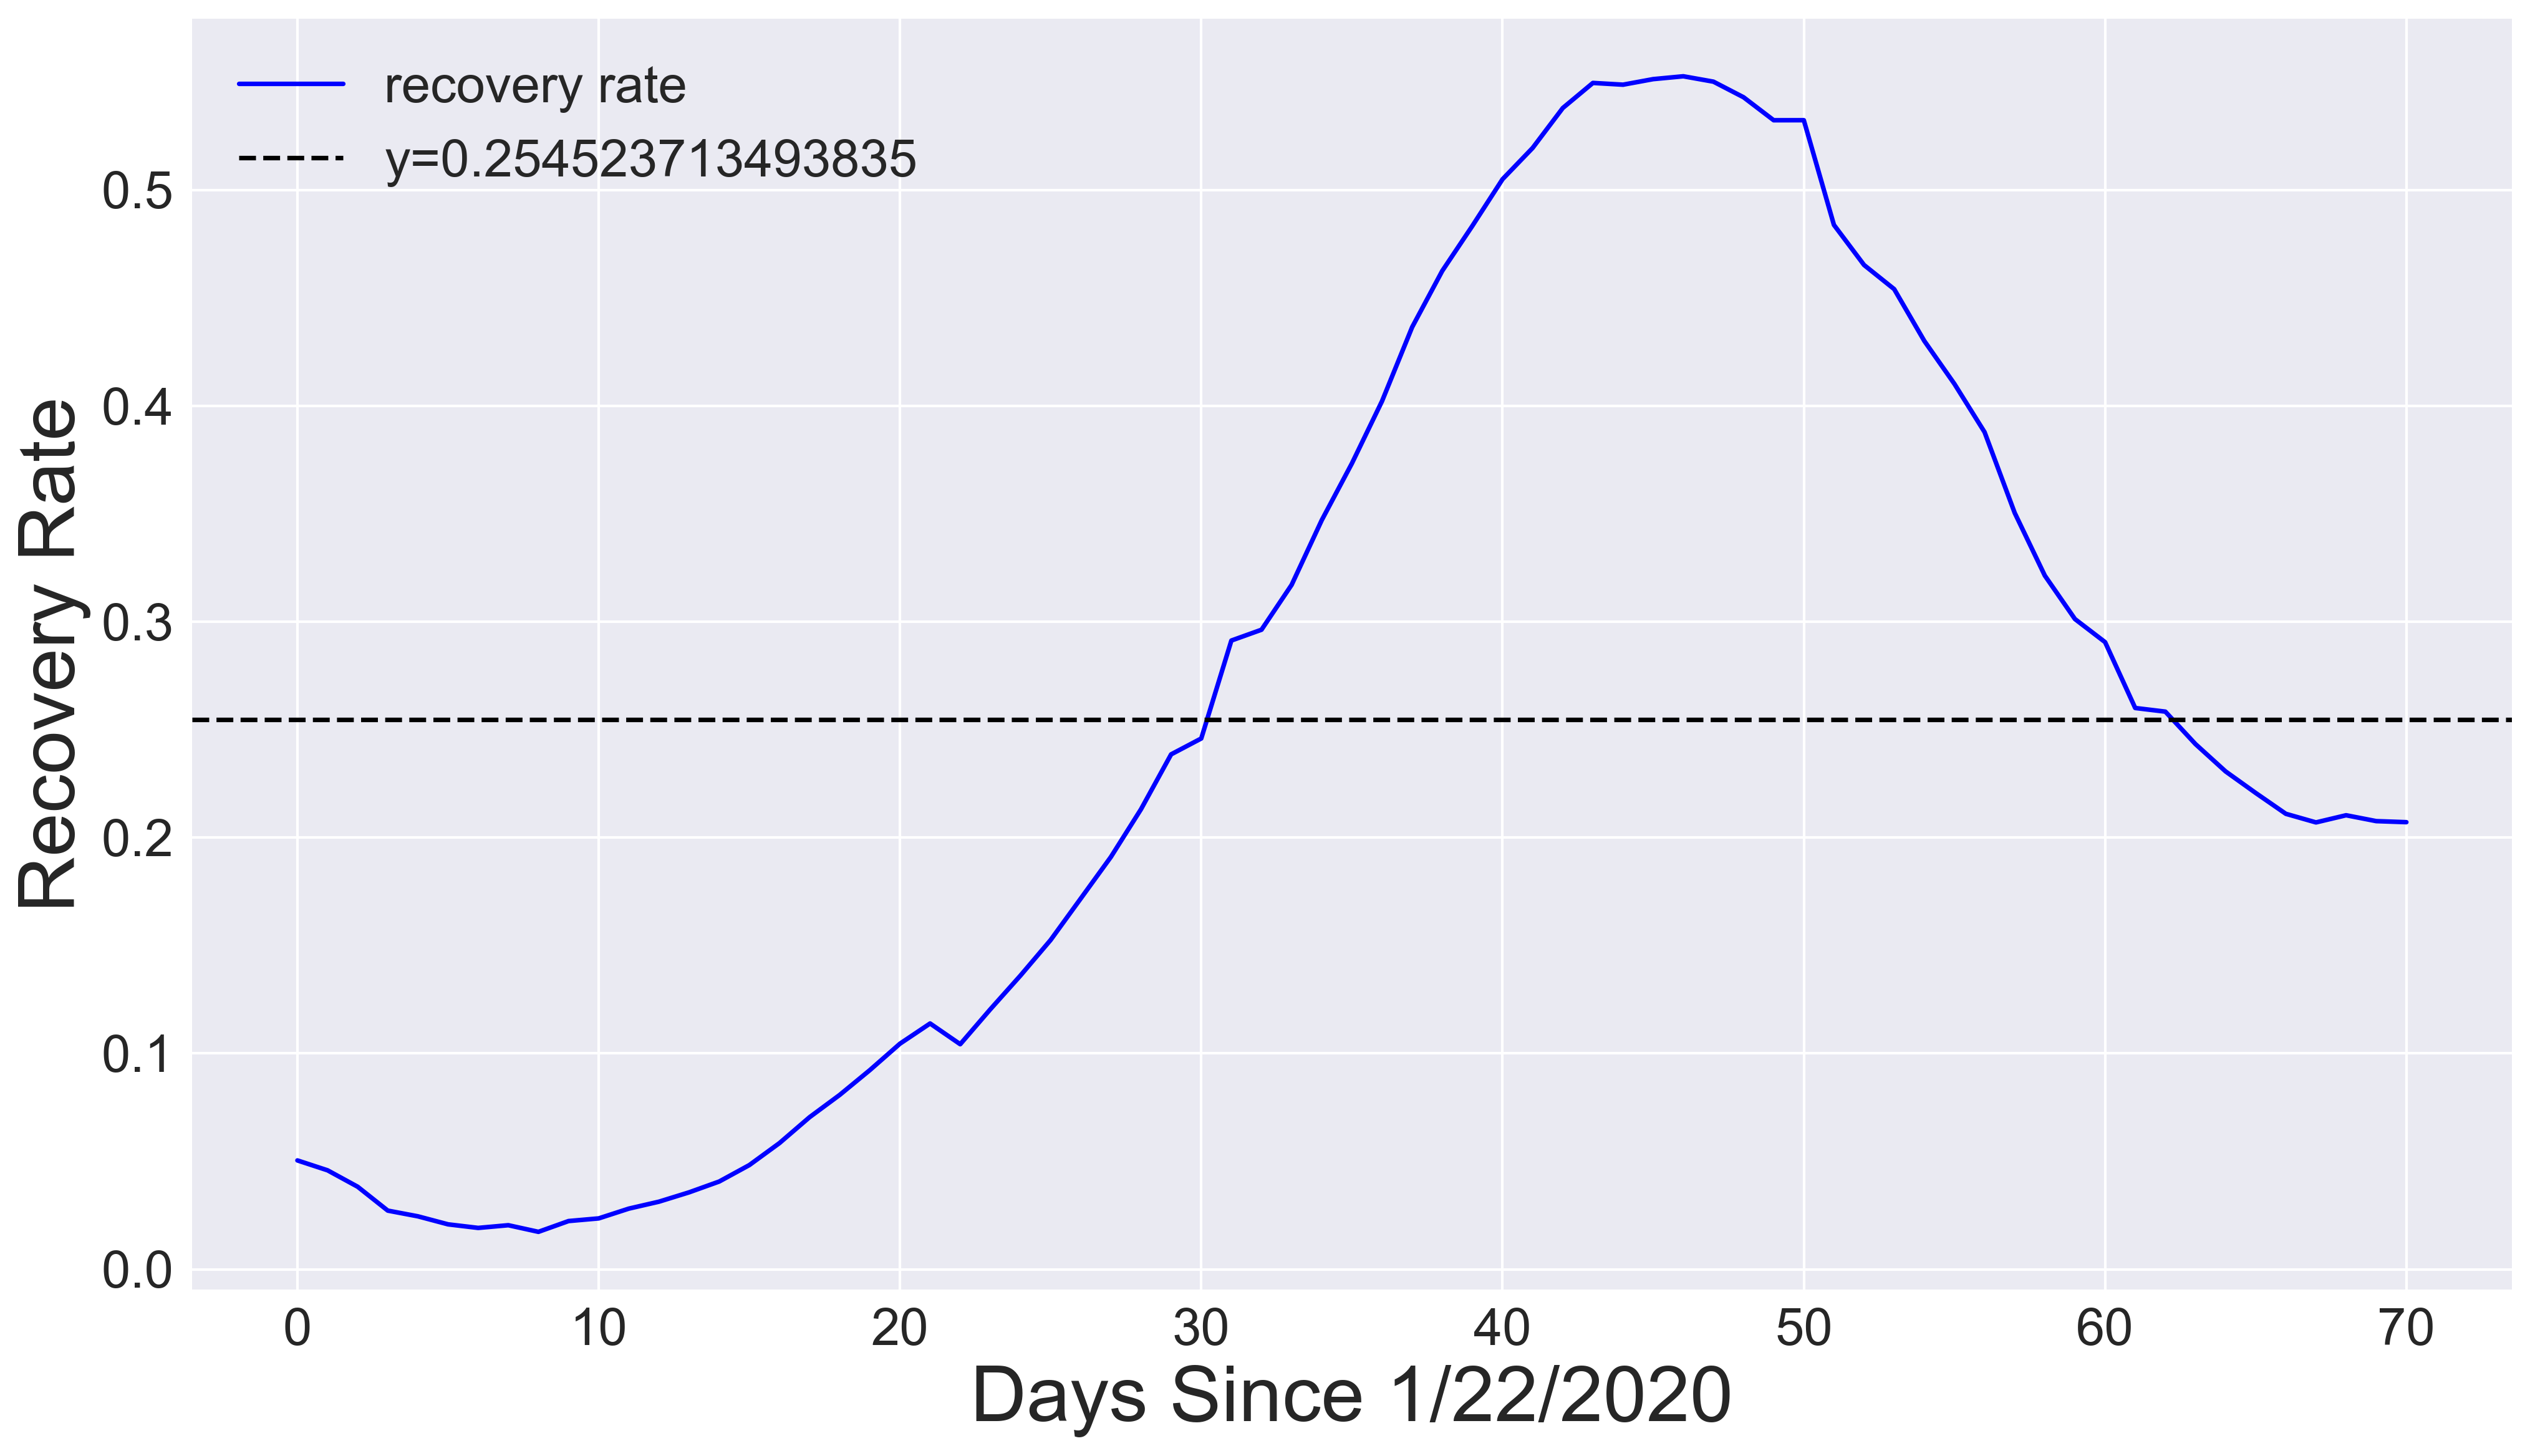

In [39]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9),dpi=300)
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('cov19-3')
plt.show()

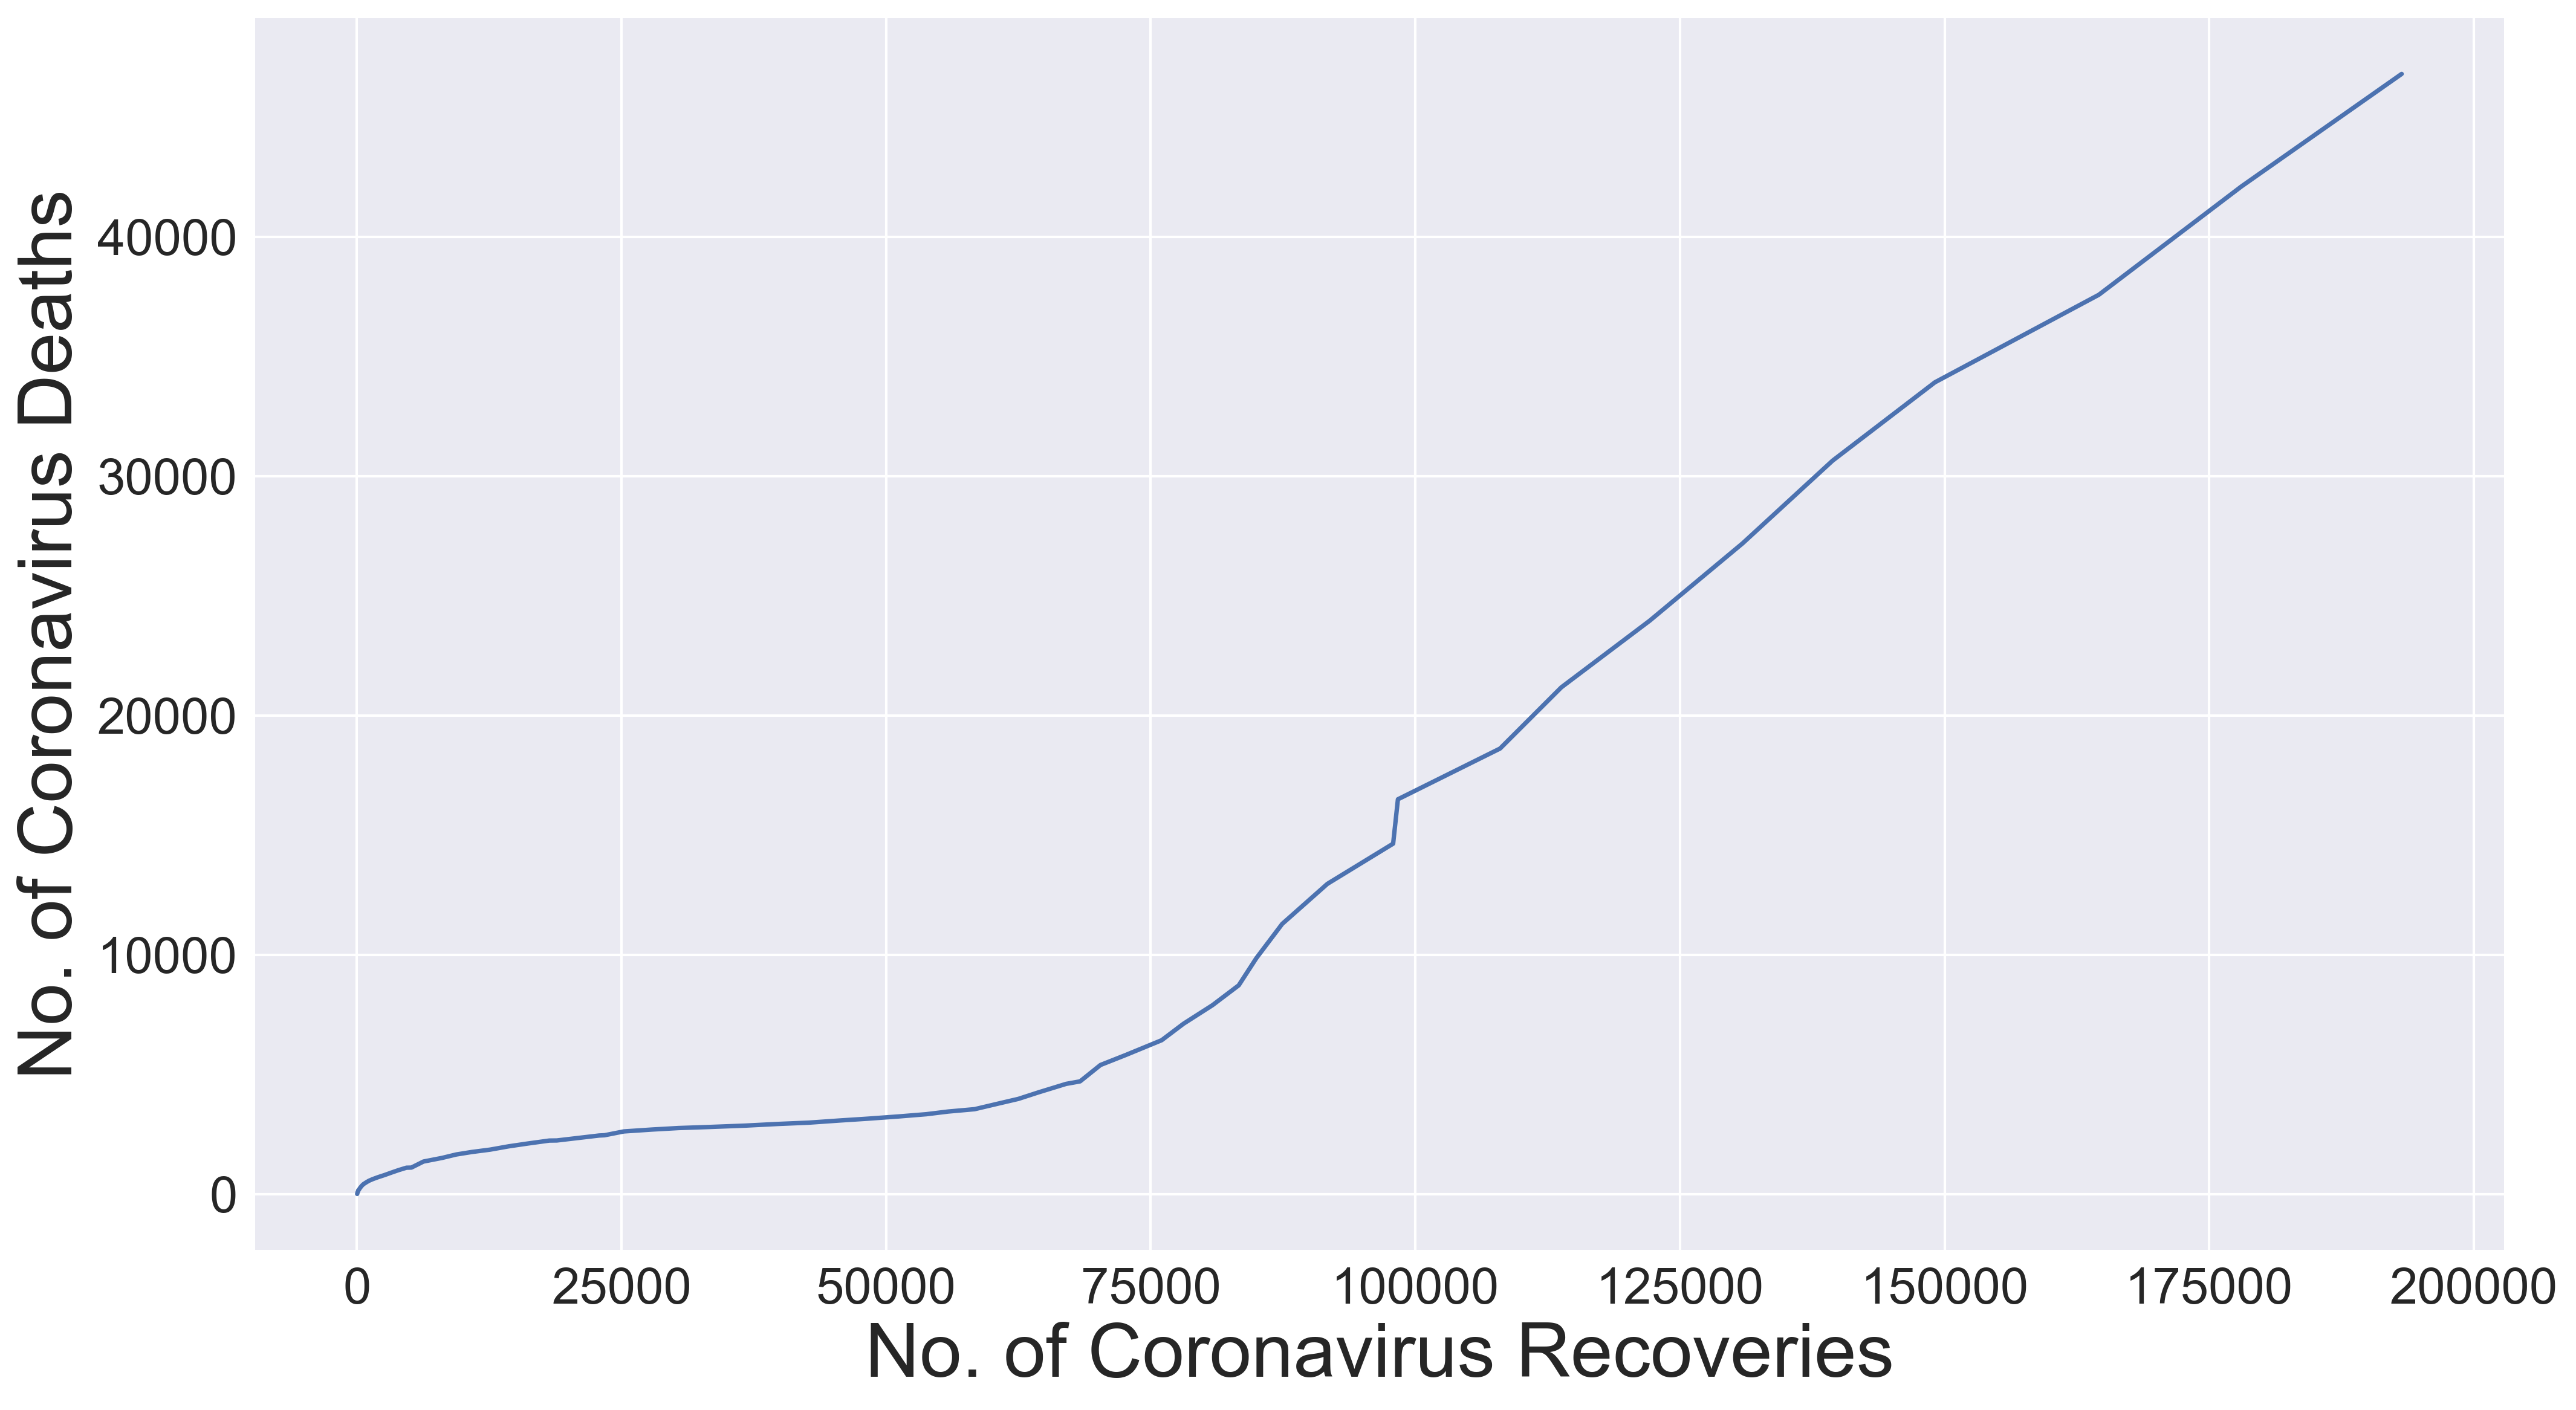

In [40]:
plt.figure(figsize=(16, 9),dpi=300)
plt.plot(total_recovered, total_deaths)
plt.xlabel('No. of Coronavirus Recoveries', size=30)
plt.ylabel('No. of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('cov19-1')
plt.show()

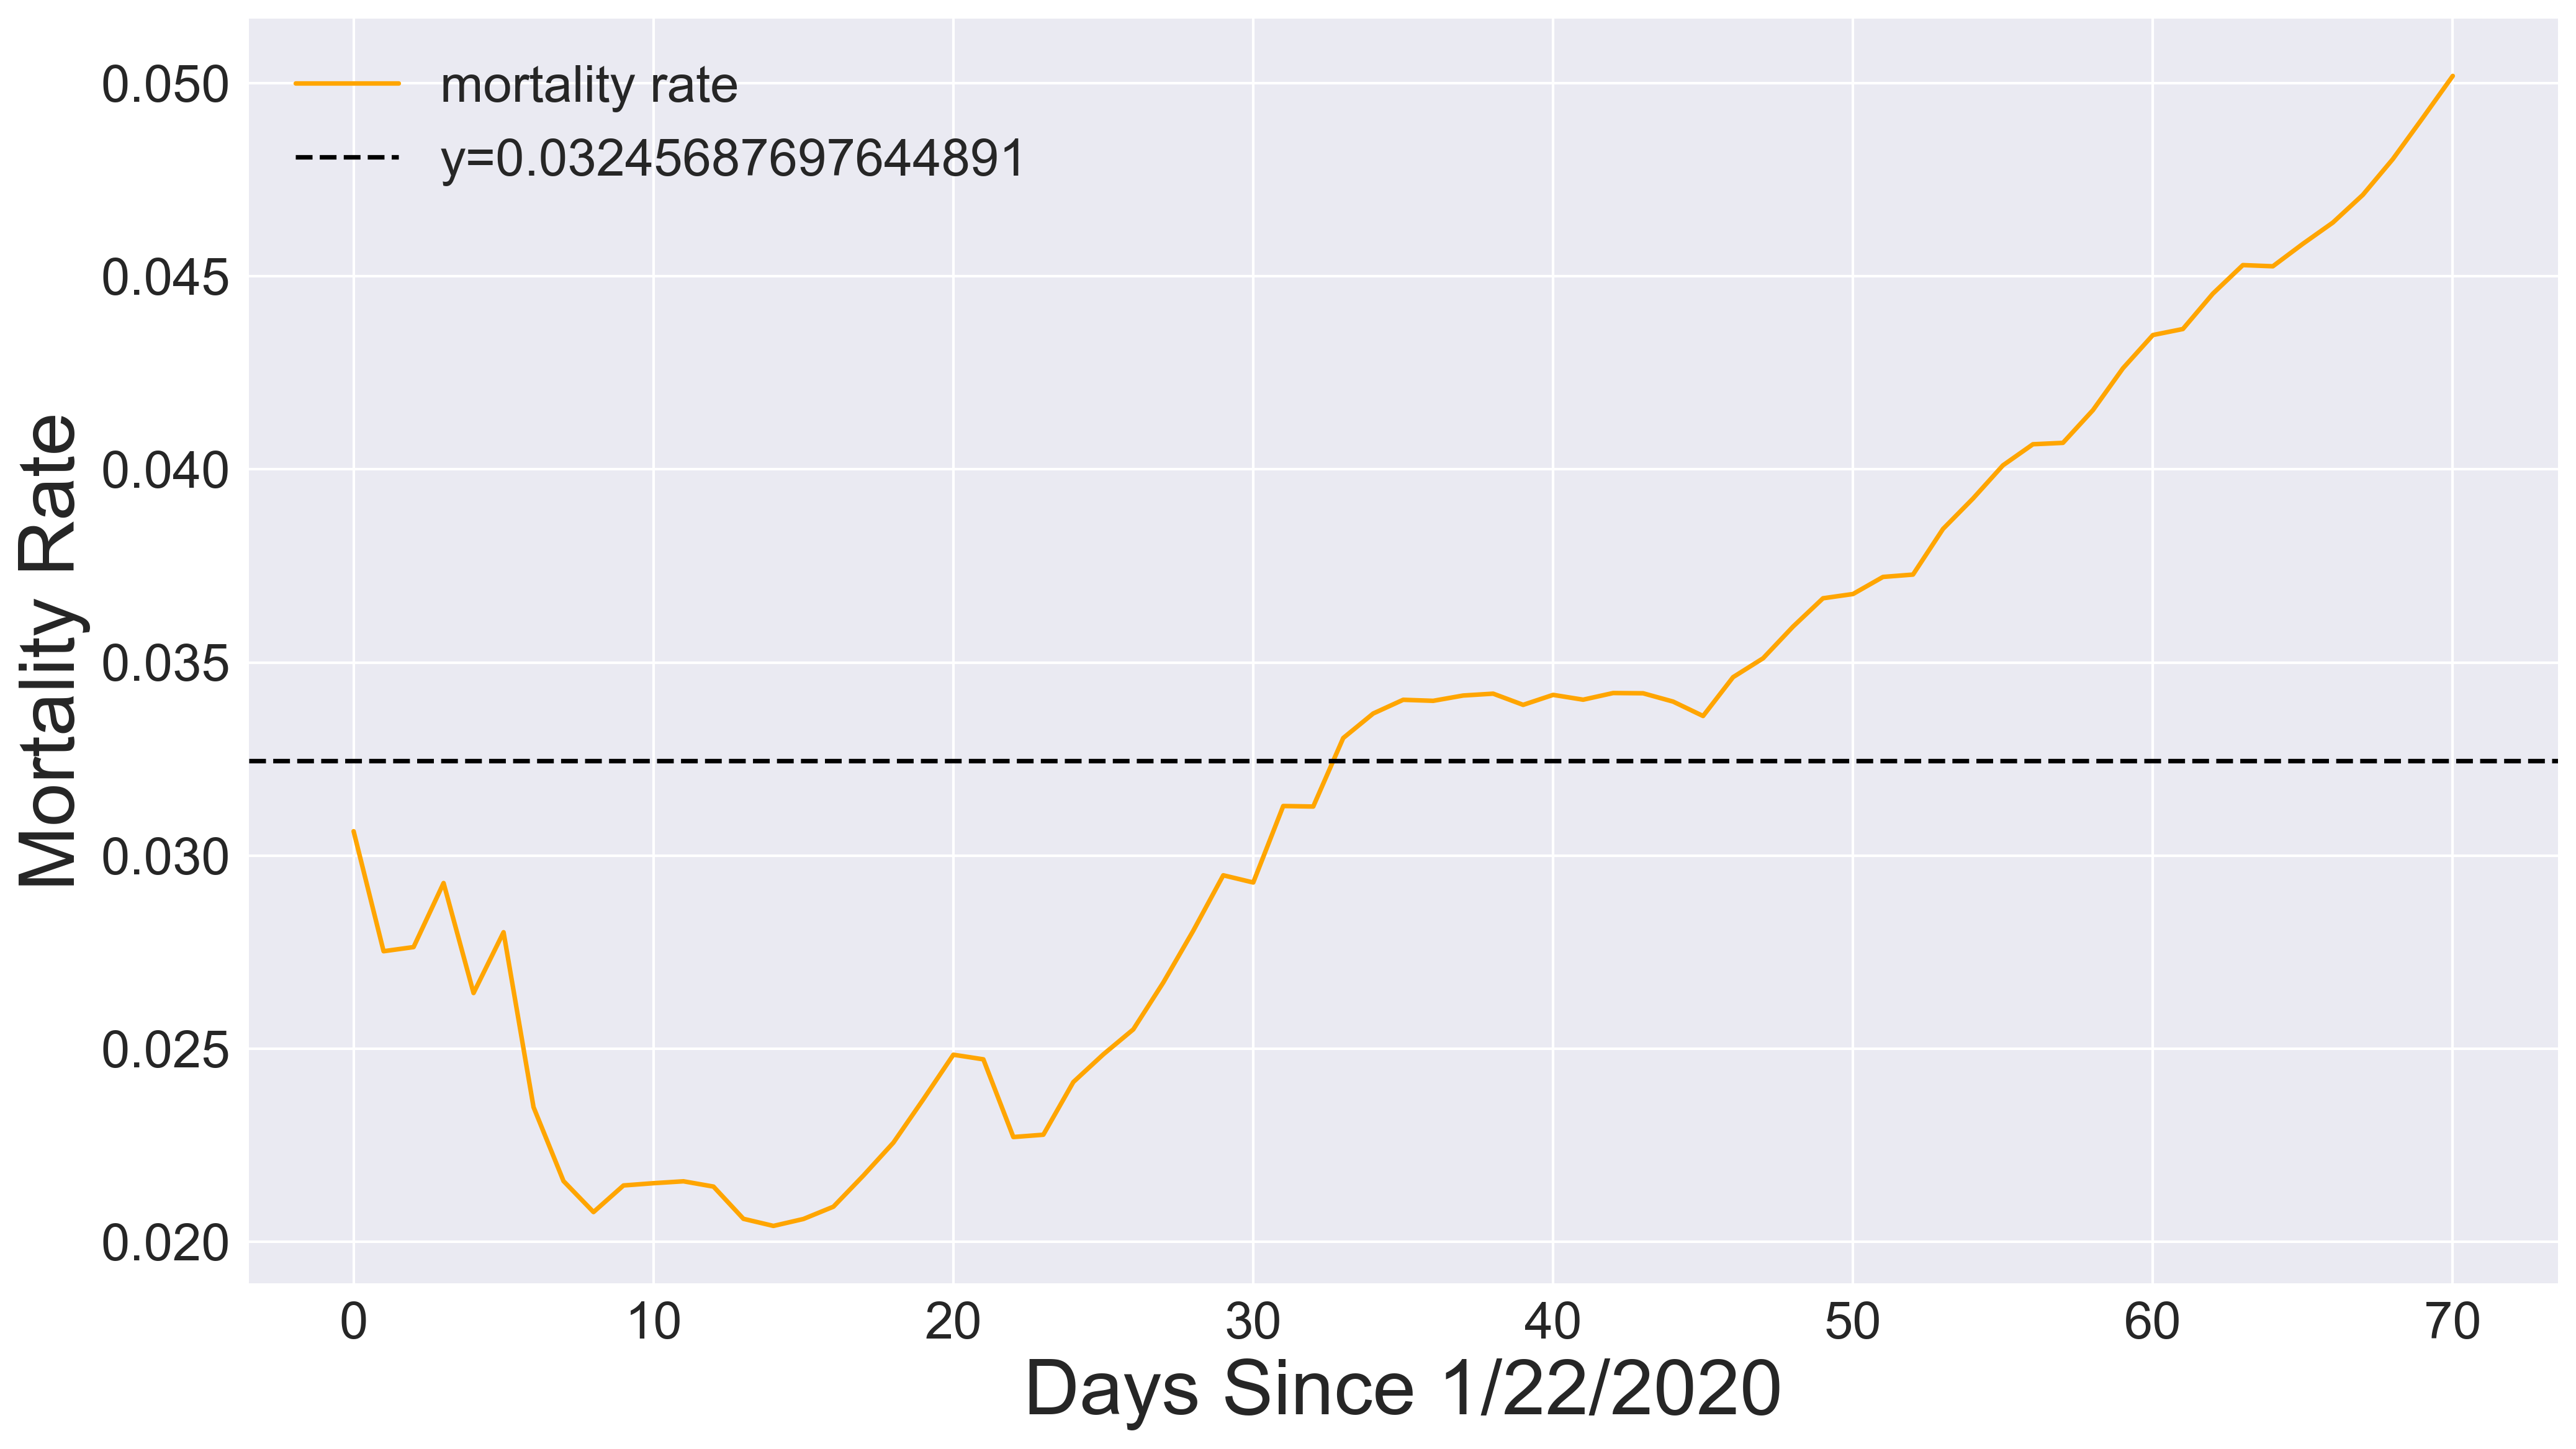

In [41]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9),dpi=300)
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('cov19-2')
plt.show()

(array([-200000.,       0.,  200000.,  400000.,  600000.,  800000.,
        1000000., 1200000., 1400000., 1600000.]),
 <a list of 10 Text yticklabel objects>)

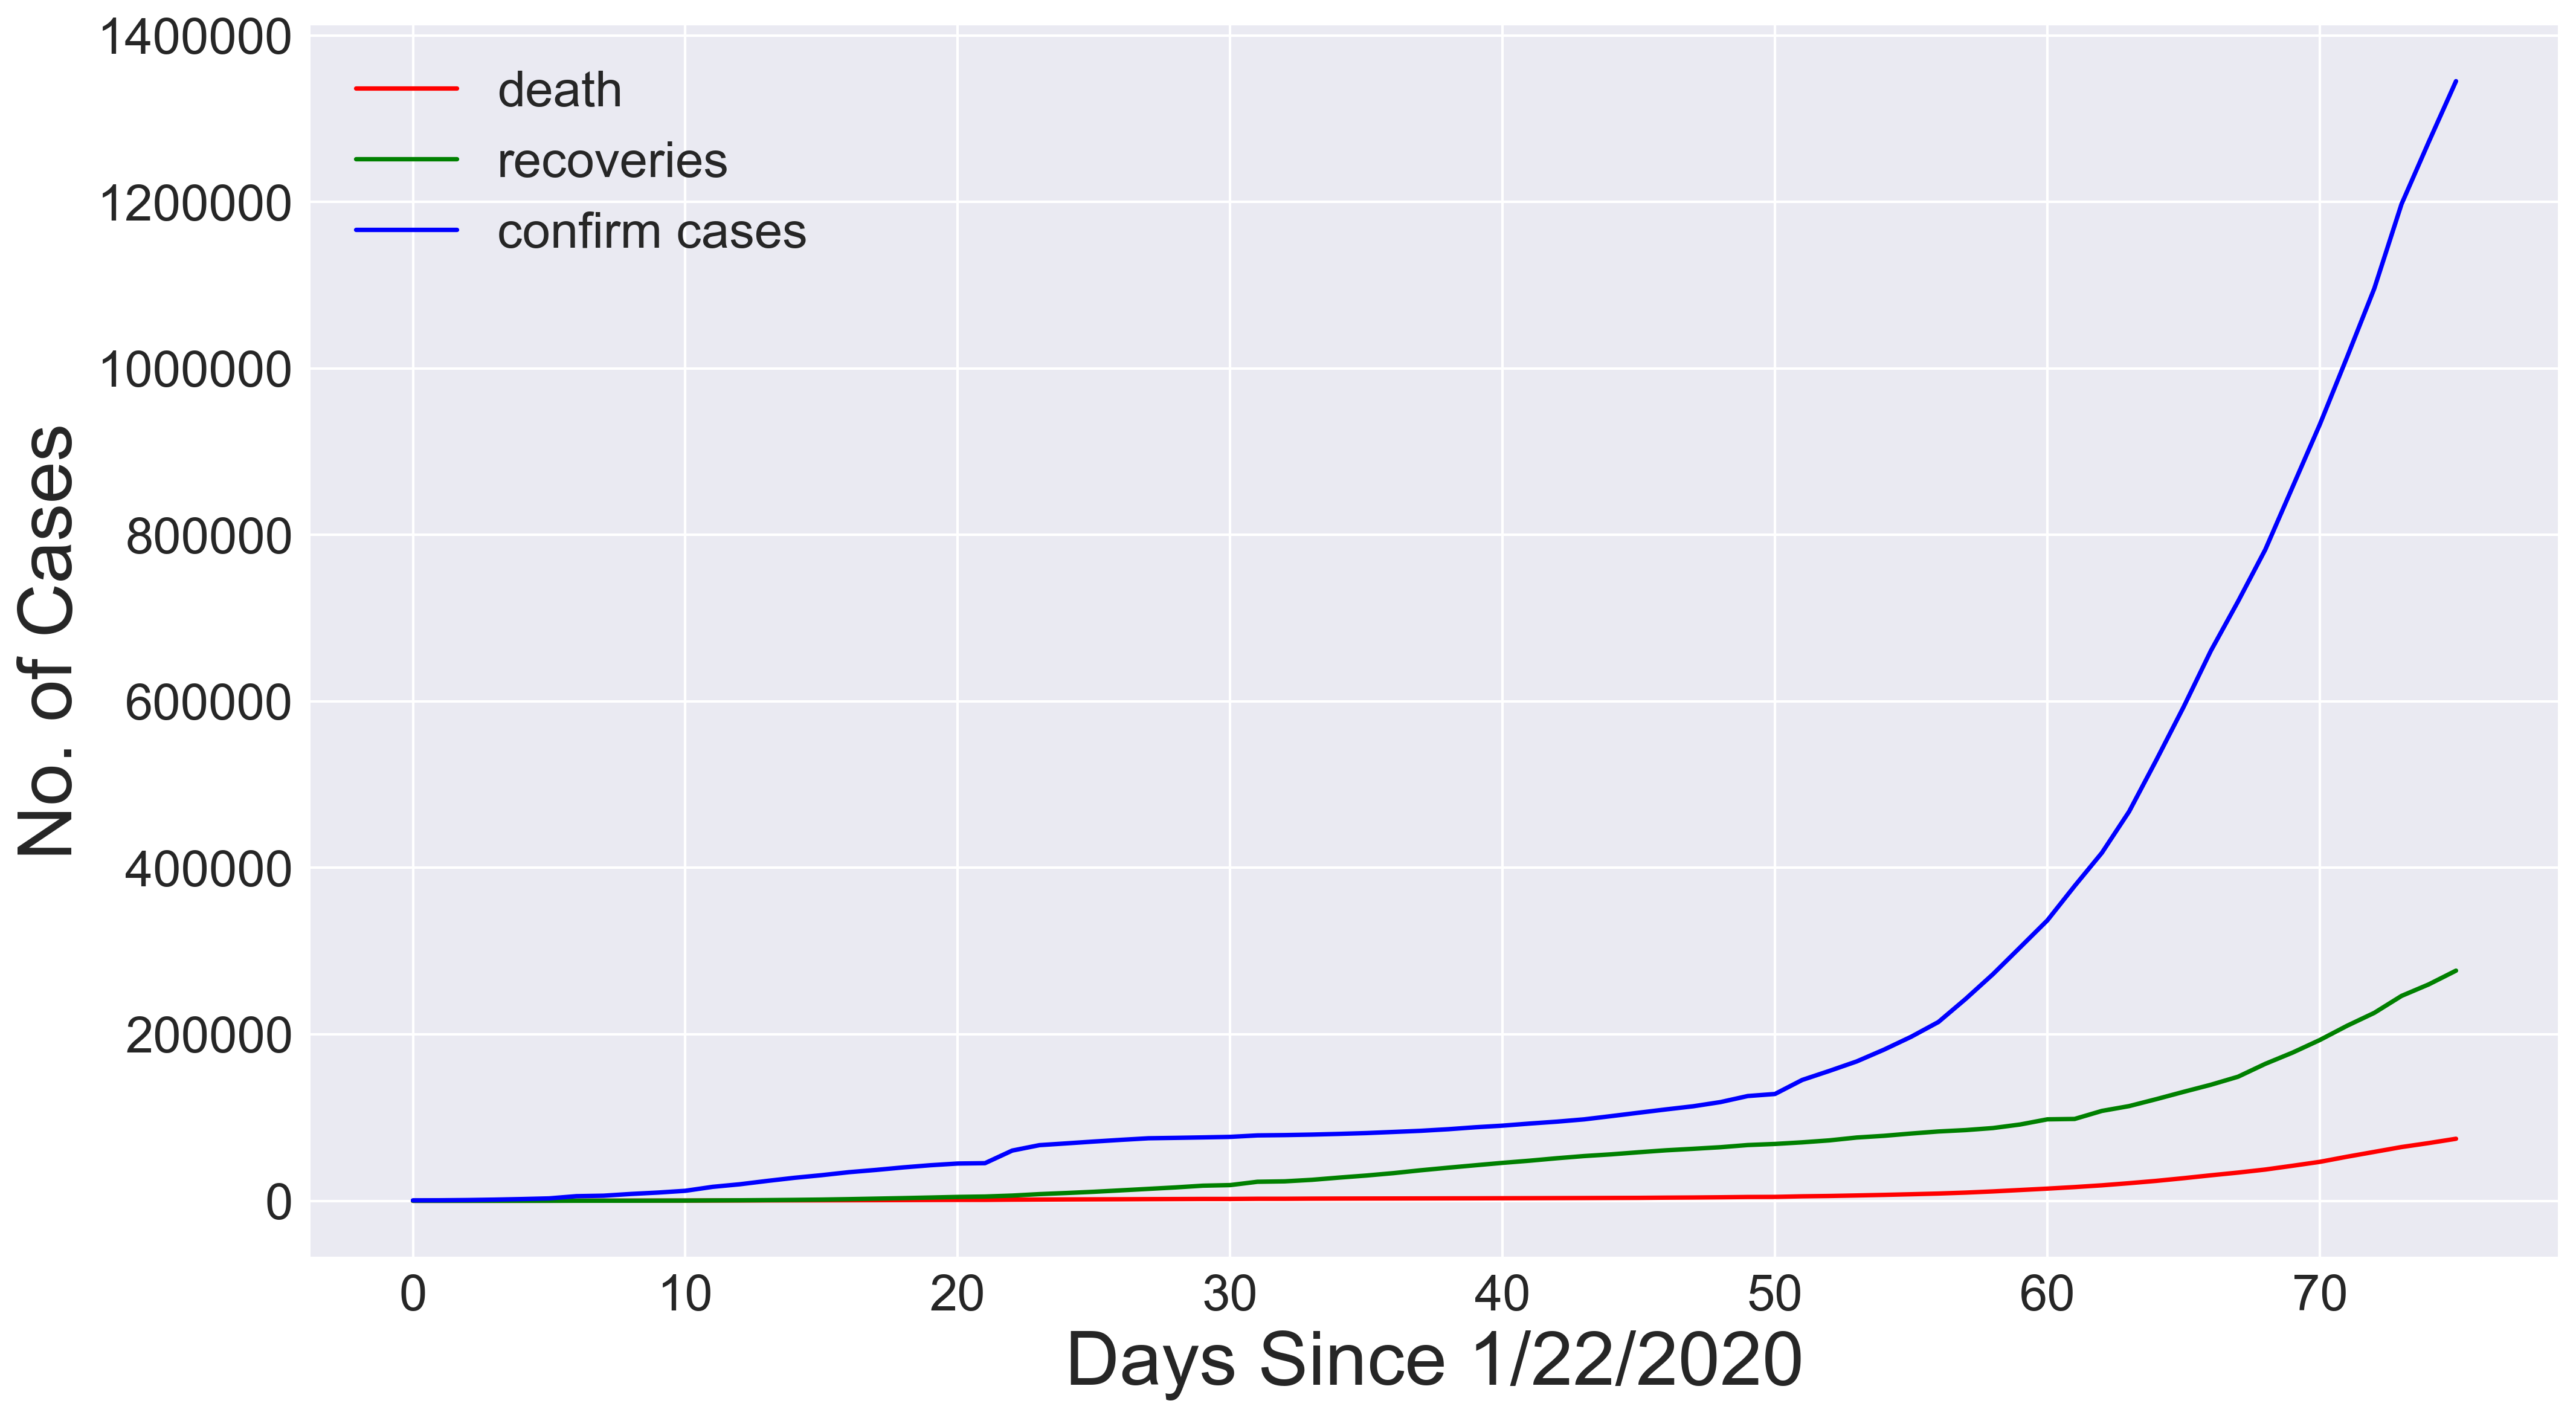

In [242]:


plt.figure(figsize=(16, 9),dpi=300)
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.plot(adjusted_dates, world_cases, color='blue')
plt.legend(['death', 'recoveries','confirm cases'], loc='best', fontsize=20)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('No. of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
#plt.savefig('cov19')